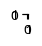

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [2]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from src.train_eval import predict_bimodal, predict_model
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

# do heatmap for retrained model

In [7]:
from src.datasets import BimodalTCRpMHCDataset
dataset_pep = FullTCRDataset(pos_df, 7, 8, 22, 6, 7, 23, 12, add_positional_encoding=True, encoding='BL50LO', pad_scale=-20)
dataset_tcr = FullTCRDataset(pos_df, 7, 8, 22, 6, 7, 23, 0, add_positional_encoding=False, encoding='BL50LO', pad_scale=-20)
loader_pep = dataset_pep.get_dataloader(1024, SequentialSampler)
loader_tcr = dataset_tcr.get_dataloader(1024, SequentialSampler)

# Doing a single model, validation fold, using cosine distance matrix

In [8]:
from src.sim_utils import make_dist_matrix, compute_cosine_distance
vae_ct = get_model('../output/240129_pepswapped/240122_PepSwapped_NormalFull_CosTrp_PosEncode_AddPep_LowMarg_fold_1_KFold_1_240126_1445_XXXXX/')
vae_nt = get_model('../output/240129_pepswapped/240122_PepSwapped_NormalFull_NoTrp_PosEncode_AddPep_LowMarg_fold_1_KFold_1_240126_1445_XXXXX/')
vae_tight = get_model('../output/240119_PosEnc_AddPep/240115_twostageFullTCR_WarmUpLowerMargin2Kepochs_KFold_1_240115_1401_TIGHT/').vae

preds_ct = predict_model(vae_ct, dataset_pep, loader_pep)
preds_nt = predict_model(vae_nt, dataset_pep, loader_pep)
preds_tight = predict_model(vae_tight, dataset_tcr, loader_tcr)

valid_ct = make_dist_matrix(preds_ct.query('partition==1'))
valid_nt = make_dist_matrix(preds_nt.query('partition==1'))
valid_tight = make_dist_matrix(preds_tight.query('partition==1'))

# retry some classic clustering methods on new computed distance matrices

In [167]:
from sklearn.cluster import KMeans, HDBSCAN, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score as ch_score
from sklearn.metrics import davies_bouldin_score as db_score

features = preds_ct.query('partition==1')
features = features[[z for z in features.columns if z.startswith('z_')]].values

# High CH and low DB = good cluster
print(ch_score(features, pred), db_score(features, pred))
random = np.random.randint(0,150,len(pred))
print(ch_score(features, random), db_score(features, random))


47.82596448232042 3.0879978497489518
0.980234178413273 6.360854926708255


<Axes: >

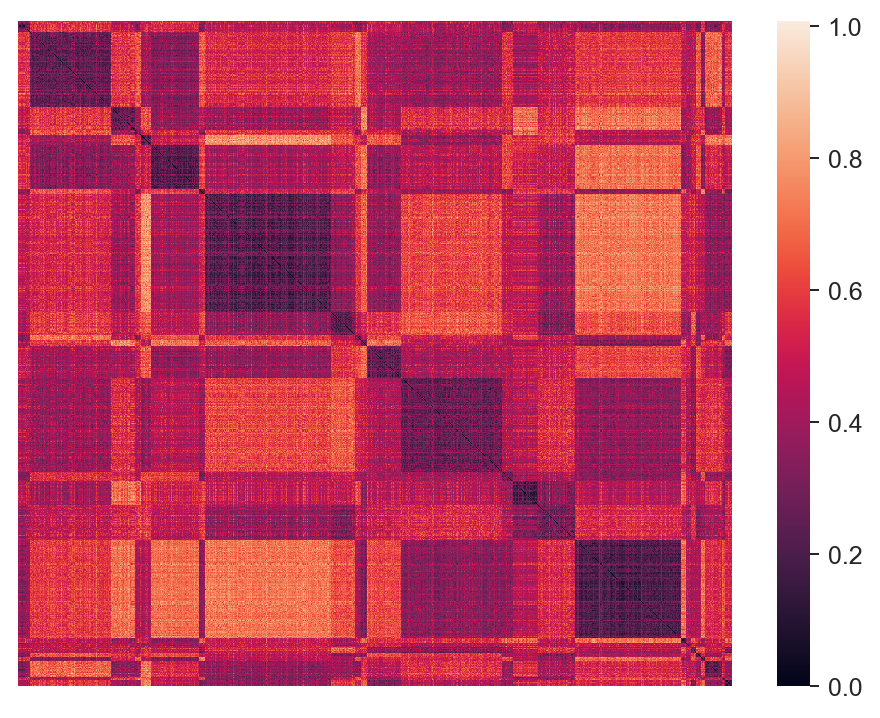

In [96]:
st= valid_ct.sort_values('peptide').drop(columns=['peptide','original_peptide'])
sns.heatmap(st[st.index], xticklabels=False, yticklabels=False)

<Axes: >

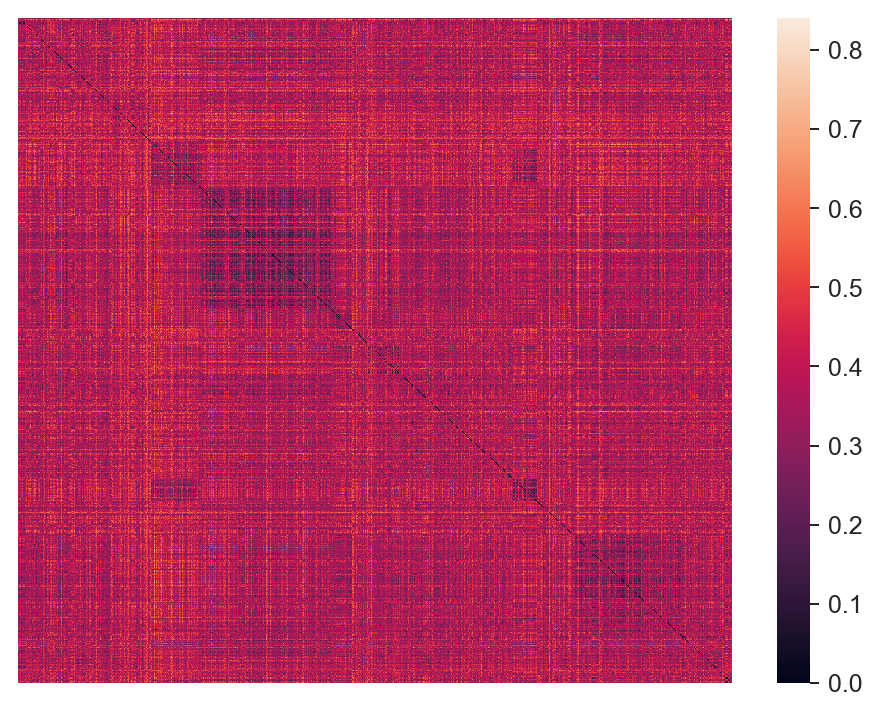

In [169]:
tight= valid_tight.sort_values('peptide').drop(columns=['peptide','original_peptide'])
sns.heatmap(tight[tight.index], xticklabels=False, yticklabels=False)

In [ ]:
hdb = HDBSCAN(min_cluster_size=2, metric='precomputed', cluster_selection_epsilon=0.13)
sample = valid_ct.copy()
pred = hdb.fit_predict(sample.drop(columns=['peptide','original_peptide']).values)
print(len(np.unique(pred)))
sample['pred_label'] = pred
gb = sample.groupby(['pred_label', 'peptide']).agg(count=('original_peptide','count'))
gb.query('pred_label!=-1')

In [192]:

features = preds_ct.query('partition==1')
features = features[[z for z in features.columns if z.startswith('z_')]].values

sample = valid_ct.copy()
results = []
for cl_size in [2,3,4,5,6,7,8]:
    for t in tqdm(np.linspace(0.08, 0.16, 100)):
        hdb = HDBSCAN(min_cluster_size=cl_size, metric='precomputed', cluster_selection_epsilon=t)
        pred = hdb.fit_predict(sample.drop(columns=['peptide','original_peptide']).values)
        results.append([cl_size, t, round(ch_score(features, pred),5), round(db_score(features, pred),5), 'HDBSCAN'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.84it/s]


# Agglo clustering

## init


In [230]:
def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix



In [ ]:
features = preds_ct.query('partition==1')
features = features[[z for z in features.columns if z.startswith('z_')]].values
sample = valid_ct.copy()

for linkage in ['average', 'single', 'complete']:
    for t in tqdm(np.linspace(0.06, 0.5, 500)):
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold = t, linkage=linkage)
        predicted_hc = clustering.fit_predict(sample.drop(columns=['peptide', 'original_peptide']).values)
        try:
            ch = round(ch_score(features, predicted_hc),5)
        except ValueError:
            continue
        try:
            db = round(db_score(features, predicted_hc),5)
        except ValueError:
            continue
        
        results.append([linkage, t, ch, db, 'hierarchical'])

In [416]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
# This is using the cosine-trained+pepswap VAE model
results = pd.DataFrame(results, columns = ['param1', 'threshold', 'CH_score', 'DB_score', 'method'])
mms = MinMaxScaler()
results['CH_scaled'] = mms.fit_transform(results['CH_score'].values.reshape((-1,1)))
results['DB_scaled_inv'] = 1+2.220446e-16-mms.fit_transform(results['DB_score'].values.reshape((-1,1)))
results['hmean'] = results.apply(lambda x: hmean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
results['mean'] = results.apply(lambda x: np.mean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
display(results.sort_values('hmean', ascending=False).head(1))
display(results.sort_values('mean', ascending=False).head(1))

param1  threshold   CH_score  DB_score        method  CH_scaled  \
1897  average   0.461202  108.49863   1.80763  hierarchical        1.0   

      DB_scaled_inv     hmean      mean  
1897       0.724611  0.840318  0.862305

param1  threshold   CH_score  DB_score        method  CH_scaled  \
1893  average   0.457675  108.49863   1.80763  hierarchical        1.0   

      DB_scaled_inv     hmean      mean  
1893       0.724611  0.840318  0.862305

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
features = preds_nt.query('partition==1')
features = features[[z for z in features.columns if z.startswith('z_')]].values
sample = valid_nt.copy()

results_nt = []
for linkage in ['average', 'single', 'complete']:
    for t in tqdm(np.linspace(0.06, 0.5, 500)):
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold = t, linkage=linkage)
        predicted_hc = clustering.fit_predict(sample.drop(columns=['peptide', 'original_peptide']).values)
        try:
            ch = round(ch_score(features, predicted_hc),5)
        except ValueError:
            continue
        try:
            db = round(db_score(features, predicted_hc),5)
        except ValueError:
            continue
        
        results_nt.append([linkage, t, ch, db, 'hierarchical'])

In [380]:
results.CH_score.max(), results.DB_score.min()

(108.49863, 0.32239)

In [415]:
results_nt = pd.DataFrame(results_nt, columns = ['param1', 'threshold', 'CH_score', 'DB_score', 'method'])
mms = MinMaxScaler()
results_nt['CH_scaled'] = mms.fit_transform(results_nt['CH_score'].values.reshape((-1,1)))
results_nt['DB_scaled_inv'] = 1+2.220446e-16-mms.fit_transform(results_nt['DB_score'].values.reshape((-1,1)))
results_nt['hmean'] = results_nt.apply(lambda x: hmean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
results_nt['mean'] = results_nt.apply(lambda x: np.mean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
display(results_nt.sort_values('hmean', ascending=False).head(1))
display(results_nt.sort_values('mean', ascending=False).head(1))
results_nt.CH_score.max(), results_nt.DB_score.min()

param1  threshold  CH_score  DB_score        method  CH_scaled  \
884  complete       0.06    22.345   0.18084  hierarchical        1.0   

     DB_scaled_inv  hmean  mean  
884            1.0    1.0   1.0

param1  threshold  CH_score  DB_score        method  CH_scaled  \
888  complete   0.063527    22.345   0.18084  hierarchical        1.0   

     DB_scaled_inv  hmean  mean  
888            1.0    1.0   1.0

(22.345, 0.18084)

In [414]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
features = preds_tight.query('partition==1')
features = features[[z for z in features.columns if z.startswith('z_')]].values
sample = valid_tight.copy()

results_tight = []
for linkage in ['average', 'single', 'complete']:
    for t in tqdm(np.linspace(0.06, 0.5, 500)):
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold = t, linkage=linkage)
        predicted_hc = clustering.fit_predict(sample.drop(columns=['peptide', 'original_peptide']).values)
        try:
            ch = round(ch_score(features, predicted_hc),5)
        except ValueError:
            continue
        try:
            db = round(db_score(features, predicted_hc),5)
        except ValueError:
            continue
        
        results_tight.append([linkage, t, ch, db, 'hierarchical'])


results_tight = pd.DataFrame(results_tight, columns = ['param1', 'threshold', 'CH_score', 'DB_score', 'method'])
mms = MinMaxScaler()
results_tight['CH_scaled'] = mms.fit_transform(results_tight['CH_score'].values.reshape((-1,1)))
results_tight['DB_scaled_inv'] = 1+2.220446e-16-mms.fit_transform(results_tight['DB_score'].values.reshape((-1,1)))
results_tight['hmean'] = results_tight.apply(lambda x: hmean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
results_tight['mean'] = results_tight.apply(lambda x: np.mean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
display(results_tight.sort_values('hmean', ascending=False).head(1))
display(results_tight.sort_values('mean', ascending=False).head(1))
results_tight.CH_score.max(), results_tight.DB_score.min()

100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.01it/s]


param1  threshold  CH_score  DB_score        method  CH_scaled  \
453  average   0.459439  32.34826   2.15759  hierarchical        1.0   

     DB_scaled_inv     hmean      mean  
453       0.328133  0.494127  0.664067

param1  threshold  CH_score  DB_score        method  CH_scaled  \
441  average   0.448858  32.34826   2.15759  hierarchical        1.0   

     DB_scaled_inv     hmean      mean  
441       0.328133  0.494127  0.664067

(32.34826, 0.28325)

In [430]:
from sklearn.decomposition import PCA
def get_aggcluster_heatmap_plot(preds, linkage='average', distance_threshold=0.457675, title='', fn='file'):
    sample = preds.query('partition==1')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3']+[z for z in preds_ct.columns if z.startswith('z_')]+['peptide', 'original_peptide']].sort_values('original_peptide')
    sample_dist_matrix = make_dist_matrix(sample)
    # Do agglomerative clustering with hyperparameters found earlier
    agg = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage=linkage, distance_threshold=distance_threshold)
    predicted_clusters = agg.fit_predict(sample_dist_matrix.drop(columns=['peptide','original_peptide']).values)
    linkage_matrix = get_linkage_matrix(agg)
    
    # Get a PCA of the features
    features = sample[[z for z in preds_ct.columns if z.startswith('z_')]+['peptide', 'original_peptide']]
    pca = PCA(n_components=15)
    pca_feats = pd.DataFrame(pca.fit_transform(features.drop(columns=['peptide', 'original_peptide']).values), columns = [f'PCA_{i}' for i in range(pca.n_components_)])
    # Create the colour scheme
    labels = features.pop('original_peptide')
    row_colors = {k:v for k,v in zip(labels.unique(), sns.color_palette('Paired', 26))}
    mapped_colors = labels.map(row_colors).reset_index(drop=True)
    
    g = sns.clustermap(pca_feats, col_cluster=False, row_linkage=linkage_matrix, col_linkage=None, row_colors=mapped_colors, cbar_pos=(.975, .35, .035, .45),
                   label=True, cmap = 'viridis', z_score=0, dendrogram_ratio=(0.2, 0))
    fig = g.fig
    ax = g.ax_heatmap
    ax.set_yticklabels([])
    ax.set_yticks([])
    fig.suptitle(title, y=1.05)
    g.savefig(f'{fn}.png', dpi=180)

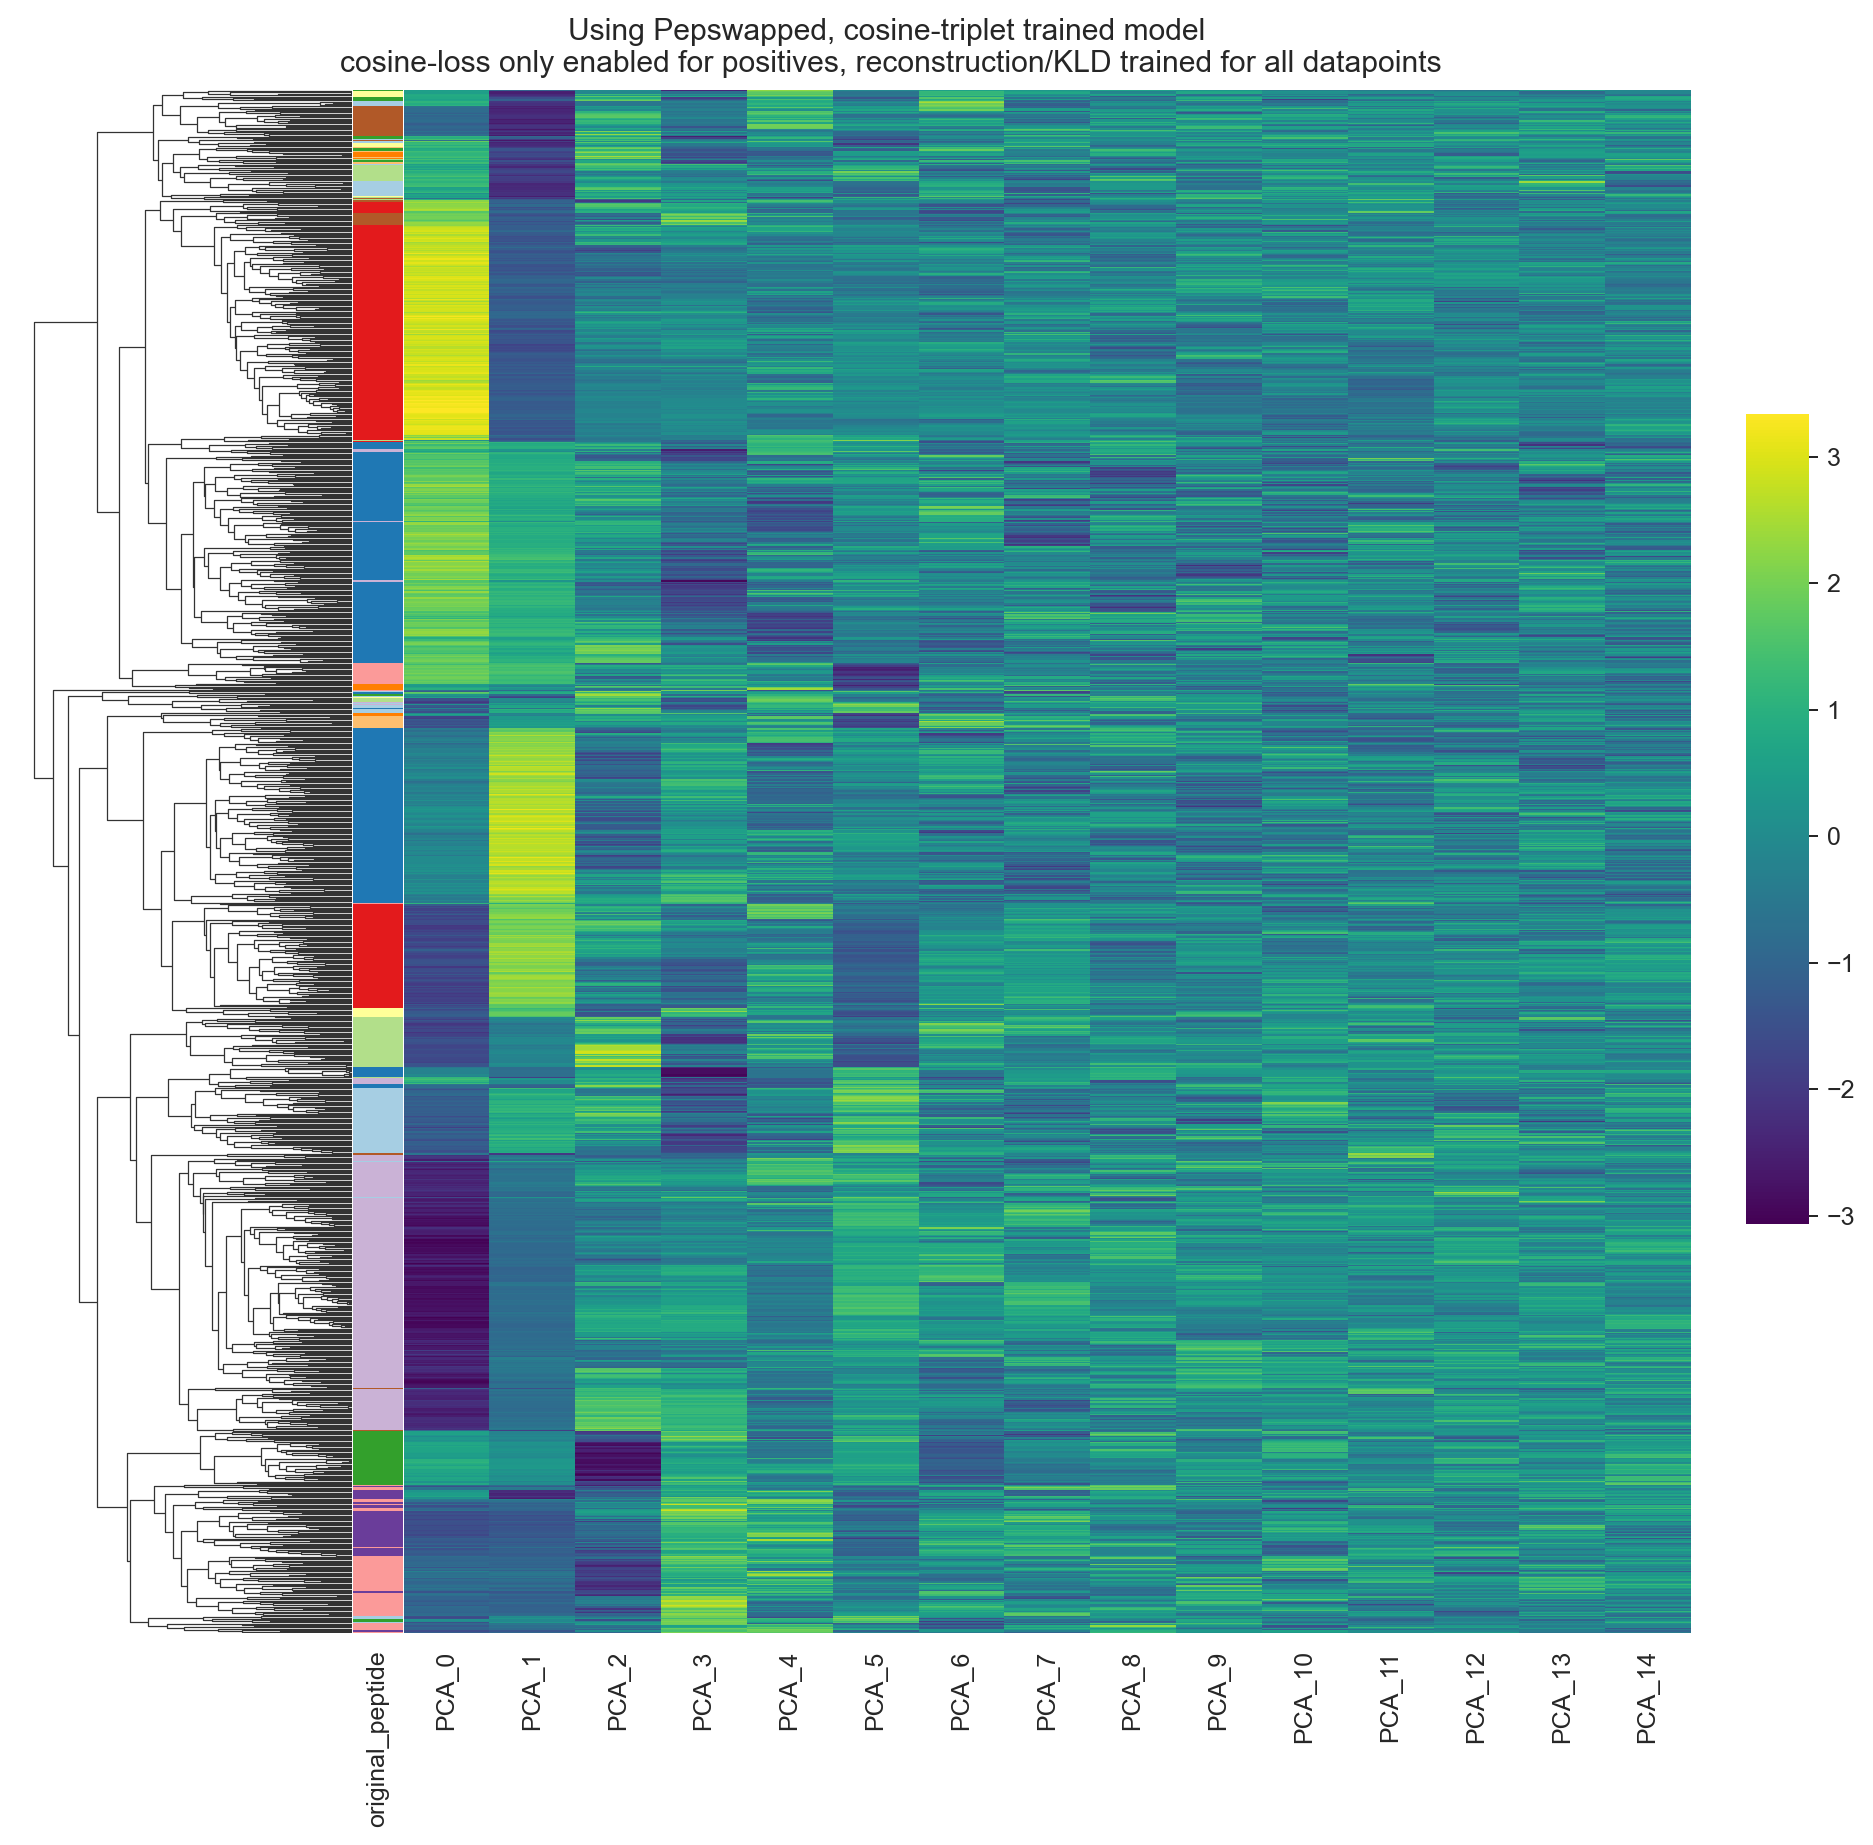

In [423]:
get_aggcluster_heatmap_plot(preds_ct, linkage='average', distance_threshold=0.461202, title='Using Pepswapped, cosine-triplet trained model \ncosine-loss only enabled for positives, reconstruction/KLD trained for all datapoints')

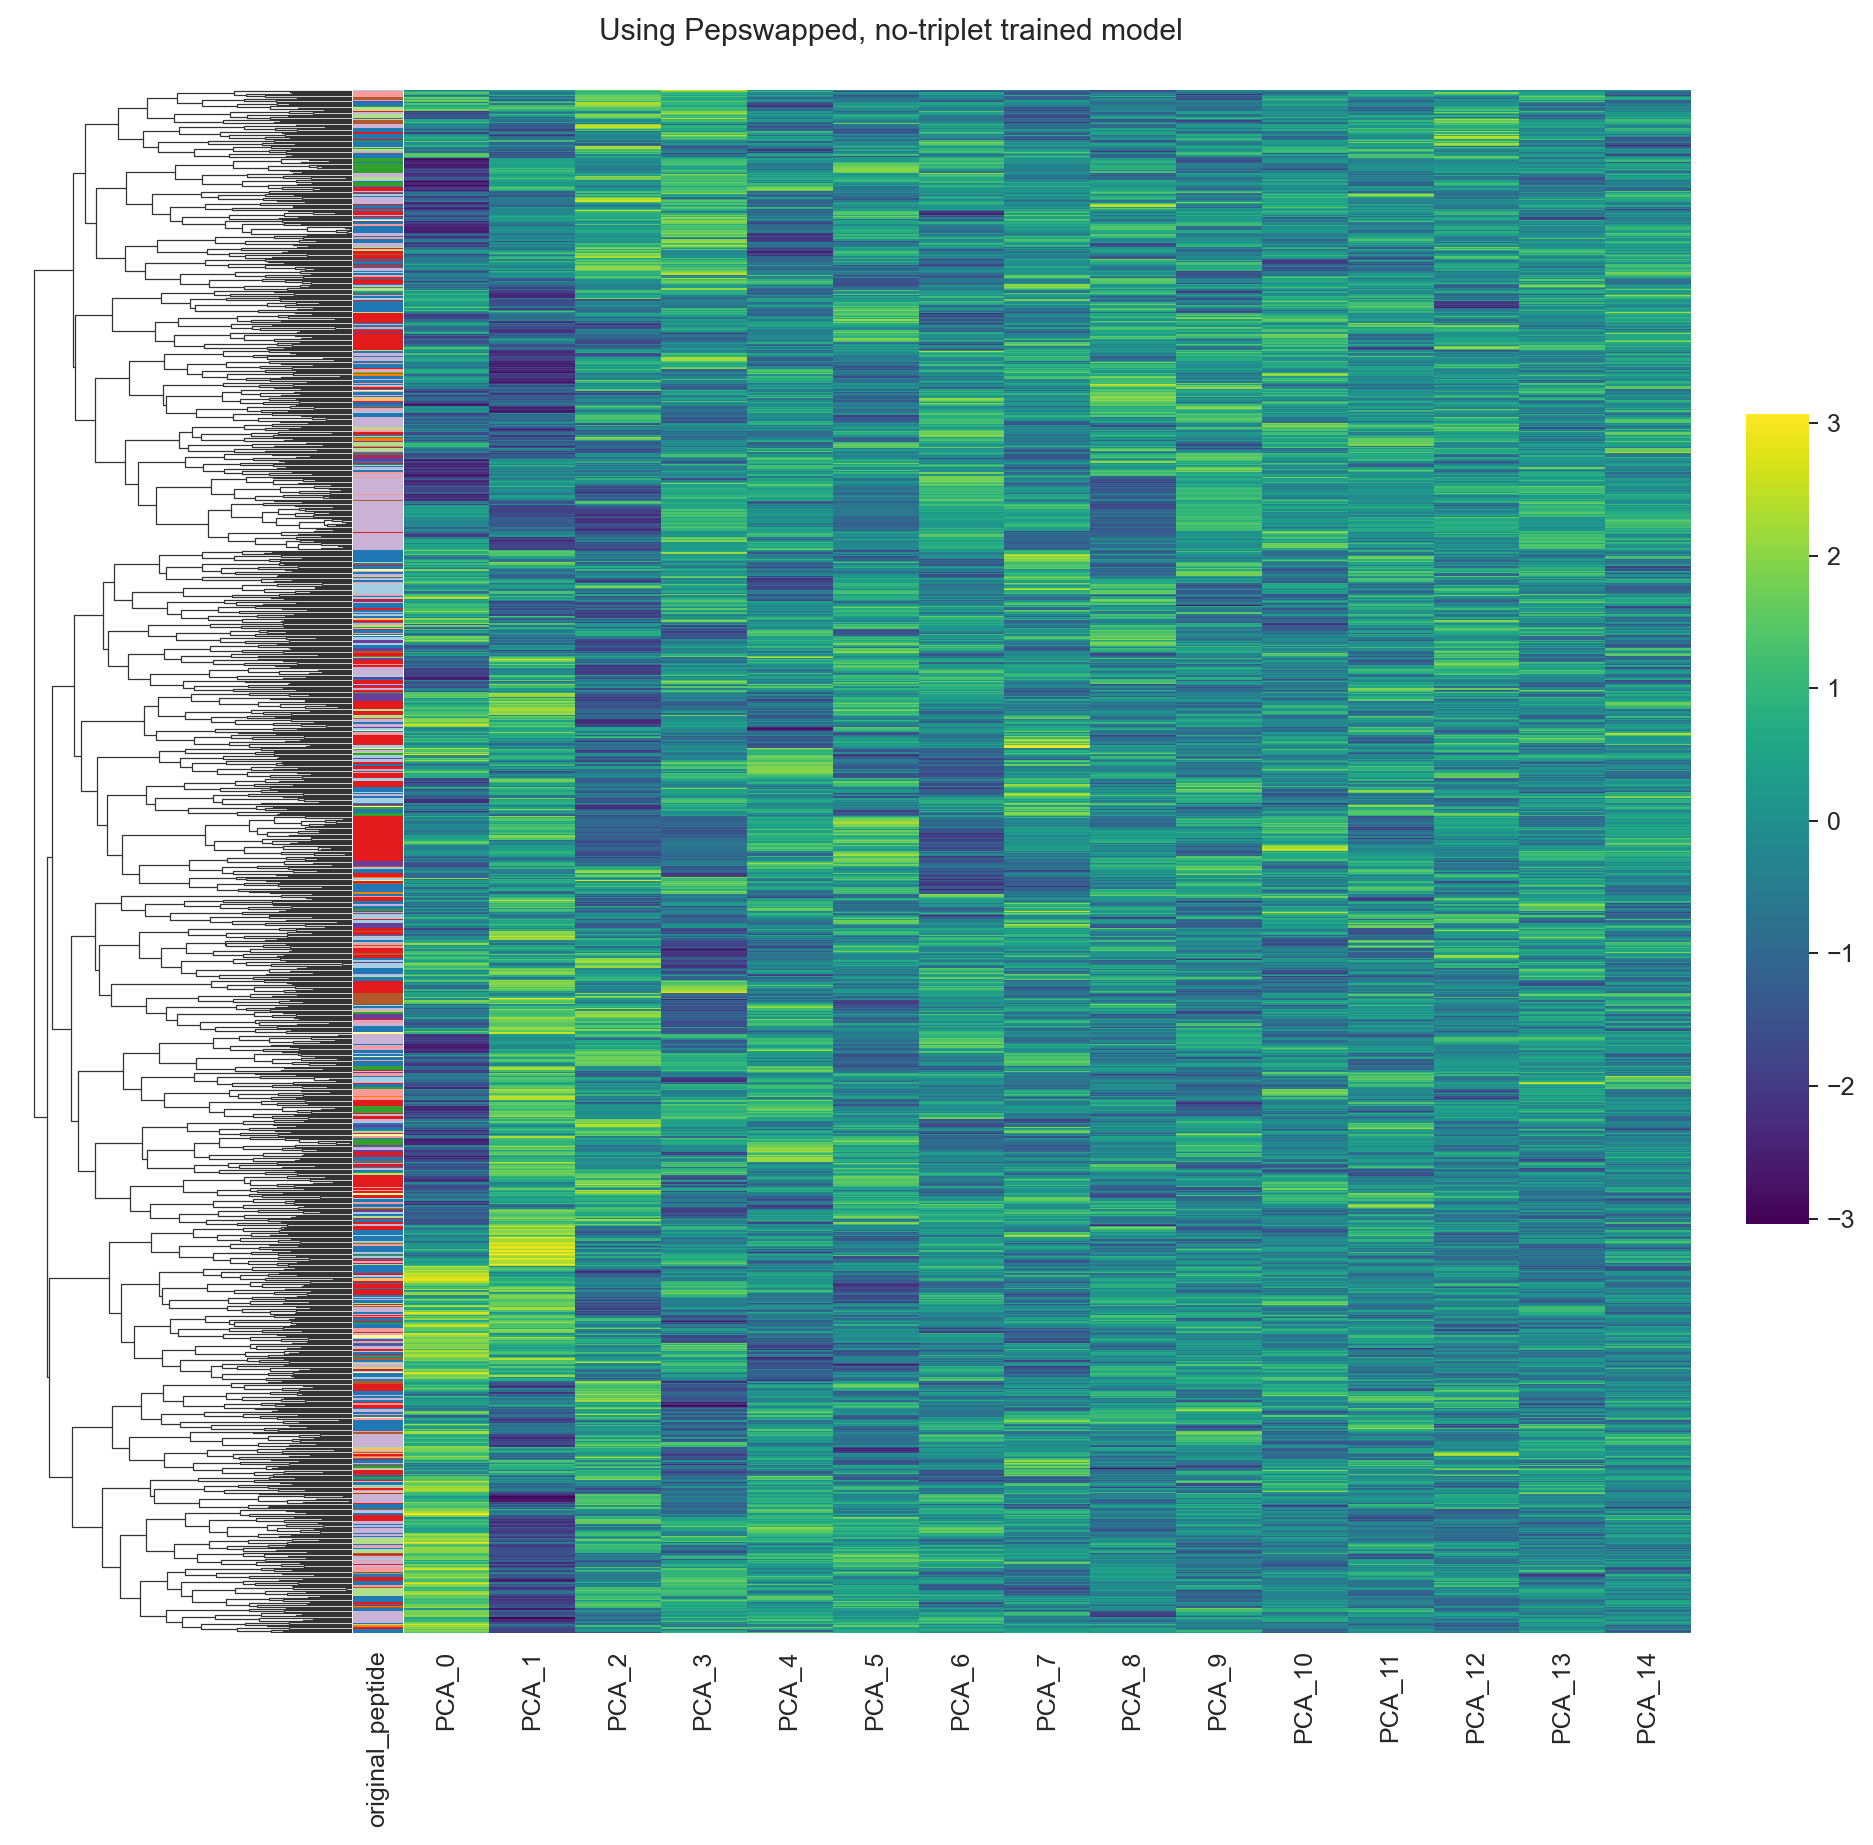

In [390]:
get_aggcluster_heatmap_plot(preds_nt, linkage='complete', distance_threshold= 0.063527, title='Using Pepswapped, no-triplet trained model')

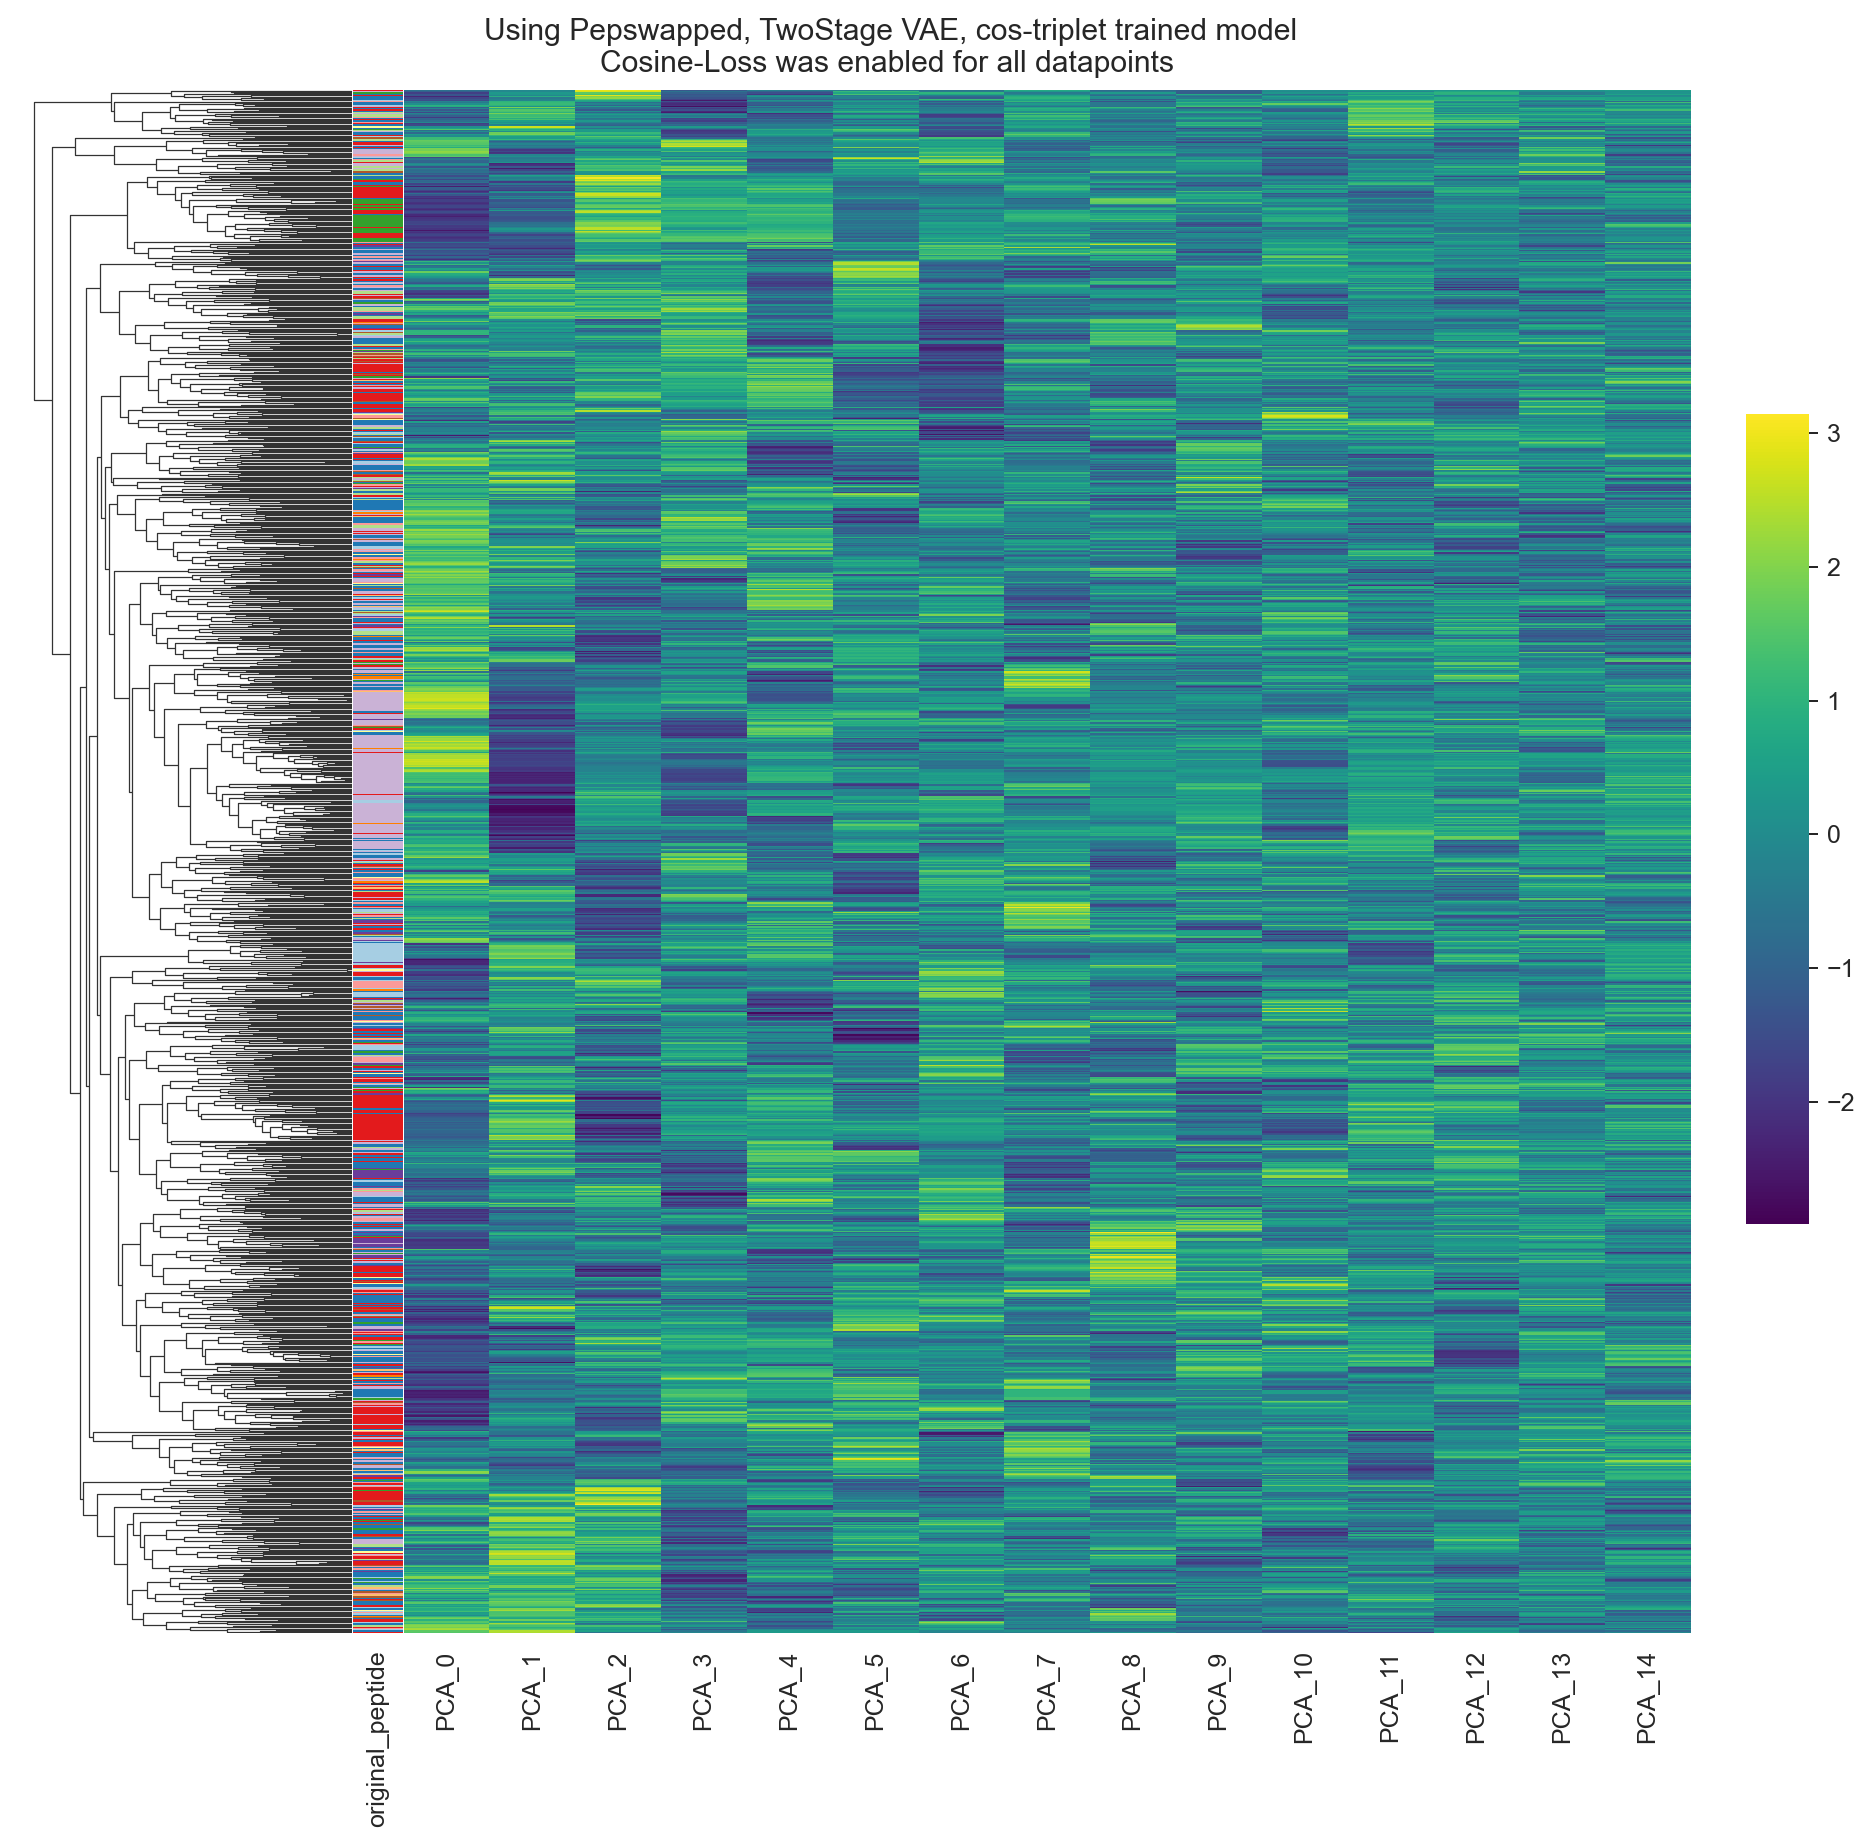

In [391]:
get_aggcluster_heatmap_plot(preds_tight, linkage='average', distance_threshold=0.448858, title='Using Pepswapped, TwoStage VAE, cos-triplet trained model\nCosine-Loss was enabled for all datapoints ')

## Do the same for 2 extra models

In [396]:
dataset_tcr.max_len_pep

0

In [400]:
from src.sim_utils import make_dist_matrix, compute_cosine_distance
from src.datasets import FullTCRDataset
dataset_addpep = FullTCRDataset(pos_df, 7,8,22,6,7,23,12, True, 'BL50LO', -20)
loader_addpep = dataset_addpep.get_dataloader(2048, SequentialSampler)

vae_2st_ct = get_model('../output/240129_pepswapped/240126_PepSwapped_2stageFull_CosTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_PEPEP/').vae
vae_2st_nt = get_model('../output/240129_pepswapped/240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_PEPEP/').vae

preds_2st_ct = predict_model(vae_2st_ct, dataset_addpep, loader_addpep)
preds_2st_nt = predict_model(vae_2st_nt, dataset_addpep, loader_addpep)

valid_2st_ct = make_dist_matrix(preds_2st_ct.query('partition==1'))
valid_2st_nt = make_dist_matrix(preds_2st_nt.query('partition==1'))

In [402]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
# Do for 
# preds_2st_ct
# valid_2st_ct

features = preds_2st_ct.query('partition==1')

features = features[[z for z in features.columns if z.startswith('z_')]].values
sample = valid_2st_ct.copy()

results_2st_ct = []
for linkage in ['average', 'single', 'complete']:
    for t in tqdm(np.linspace(0.06, 0.5, 500)):
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold = t, linkage=linkage)
        predicted_hc = clustering.fit_predict(sample.drop(columns=['peptide', 'original_peptide']).values)
        try:
            ch = round(ch_score(features, predicted_hc),5)
        except ValueError:
            continue
        try:
            db = round(db_score(features, predicted_hc),5)
        except ValueError:
            continue
        
        results_2st_ct.append([linkage, t, ch, db, 'hierarchical'])


results_2st_ct = pd.DataFrame(results_2st_ct, columns = ['param1', 'threshold', 'CH_score', 'DB_score', 'method'])
mms = MinMaxScaler()
results_2st_ct['CH_scaled'] = mms.fit_transform(results_2st_ct['CH_score'].values.reshape((-1,1)))
results_2st_ct['DB_scaled_inv'] = 1+2.220446e-16-mms.fit_transform(results_2st_ct['DB_score'].values.reshape((-1,1)))
results_2st_ct['hmean'] = results_2st_ct.apply(lambda x: hmean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
results_2st_ct['mean'] = results_2st_ct.apply(lambda x: np.mean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
display(results_2st_ct.sort_values('hmean', ascending=False).head(5))
display(results_2st_ct.sort_values('mean', ascending=False).head(5))
results_2st_ct.CH_score.max(), results_2st_ct.DB_score.min()

100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.82it/s]


param1  threshold  CH_score  DB_score        method  CH_scaled  \
226  average   0.259279  79.43849   1.76006  hierarchical   0.467679   
225  average   0.258397  79.43849   1.76006  hierarchical   0.467679   
224  average   0.257515  79.43849   1.76006  hierarchical   0.467679   
223  average   0.256633  79.43849   1.76006  hierarchical   0.467679   
222  average   0.255752  79.43849   1.76006  hierarchical   0.467679   

     DB_scaled_inv    hmean      mean  
226       0.336751  0.39156  0.402215  
225       0.336751  0.39156  0.402215  
224       0.336751  0.39156  0.402215  
223       0.336751  0.39156  0.402215  
222       0.336751  0.39156  0.402215

param1  threshold   CH_score  DB_score        method  CH_scaled  \
309  average   0.332465  167.84119   2.10542  hierarchical        1.0   
352  average   0.370381  167.84119   2.10542  hierarchical        1.0   
340  average   0.359800  167.84119   2.10542  hierarchical        1.0   
341  average   0.360681  167.84119   2.10542  hierarchical        1.0   
342  average   0.361563  167.84119   2.10542  hierarchical        1.0   

     DB_scaled_inv     hmean      mean  
309       0.125242  0.222604  0.562621  
352       0.125242  0.222604  0.562621  
340       0.125242  0.222604  0.562621  
341       0.125242  0.222604  0.562621  
342       0.125242  0.222604  0.562621

(167.84119, 0.67708)

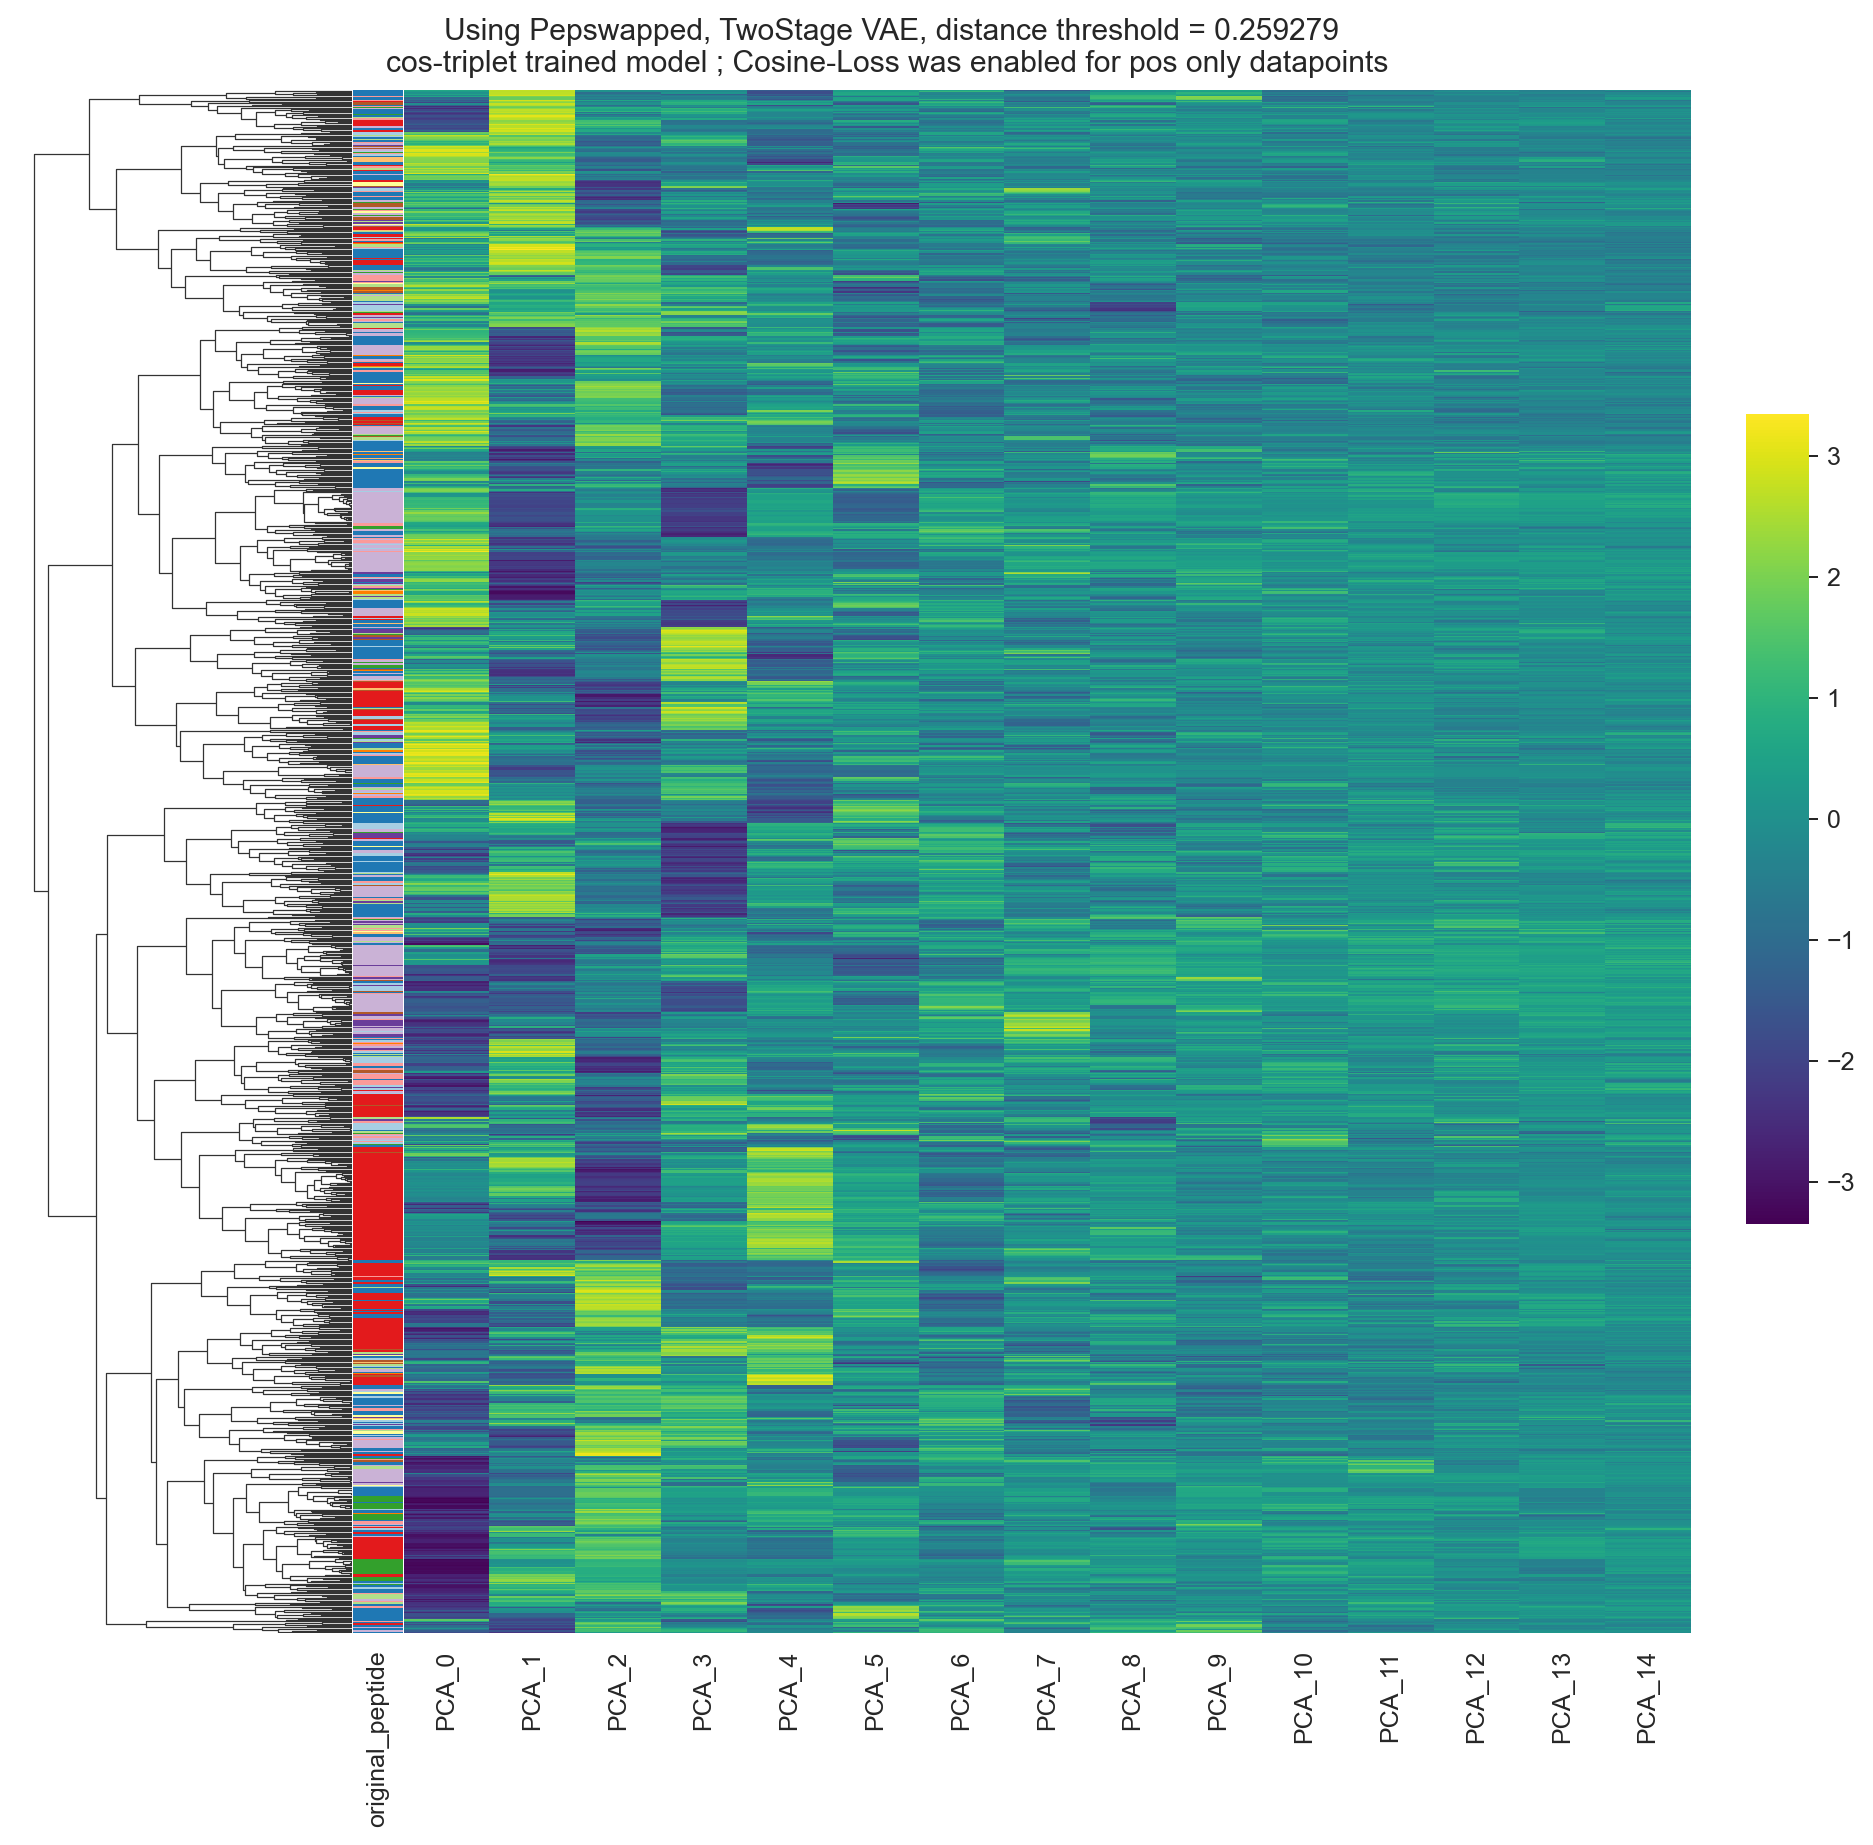

In [410]:
get_aggcluster_heatmap_plot(preds_2st_ct, linkage='average', distance_threshold=0.259279, title='Using Pepswapped, TwoStage VAE, distance threshold = 0.259279'\
                            '\ncos-triplet trained model ; Cosine-Loss was enabled for pos only datapoints ')


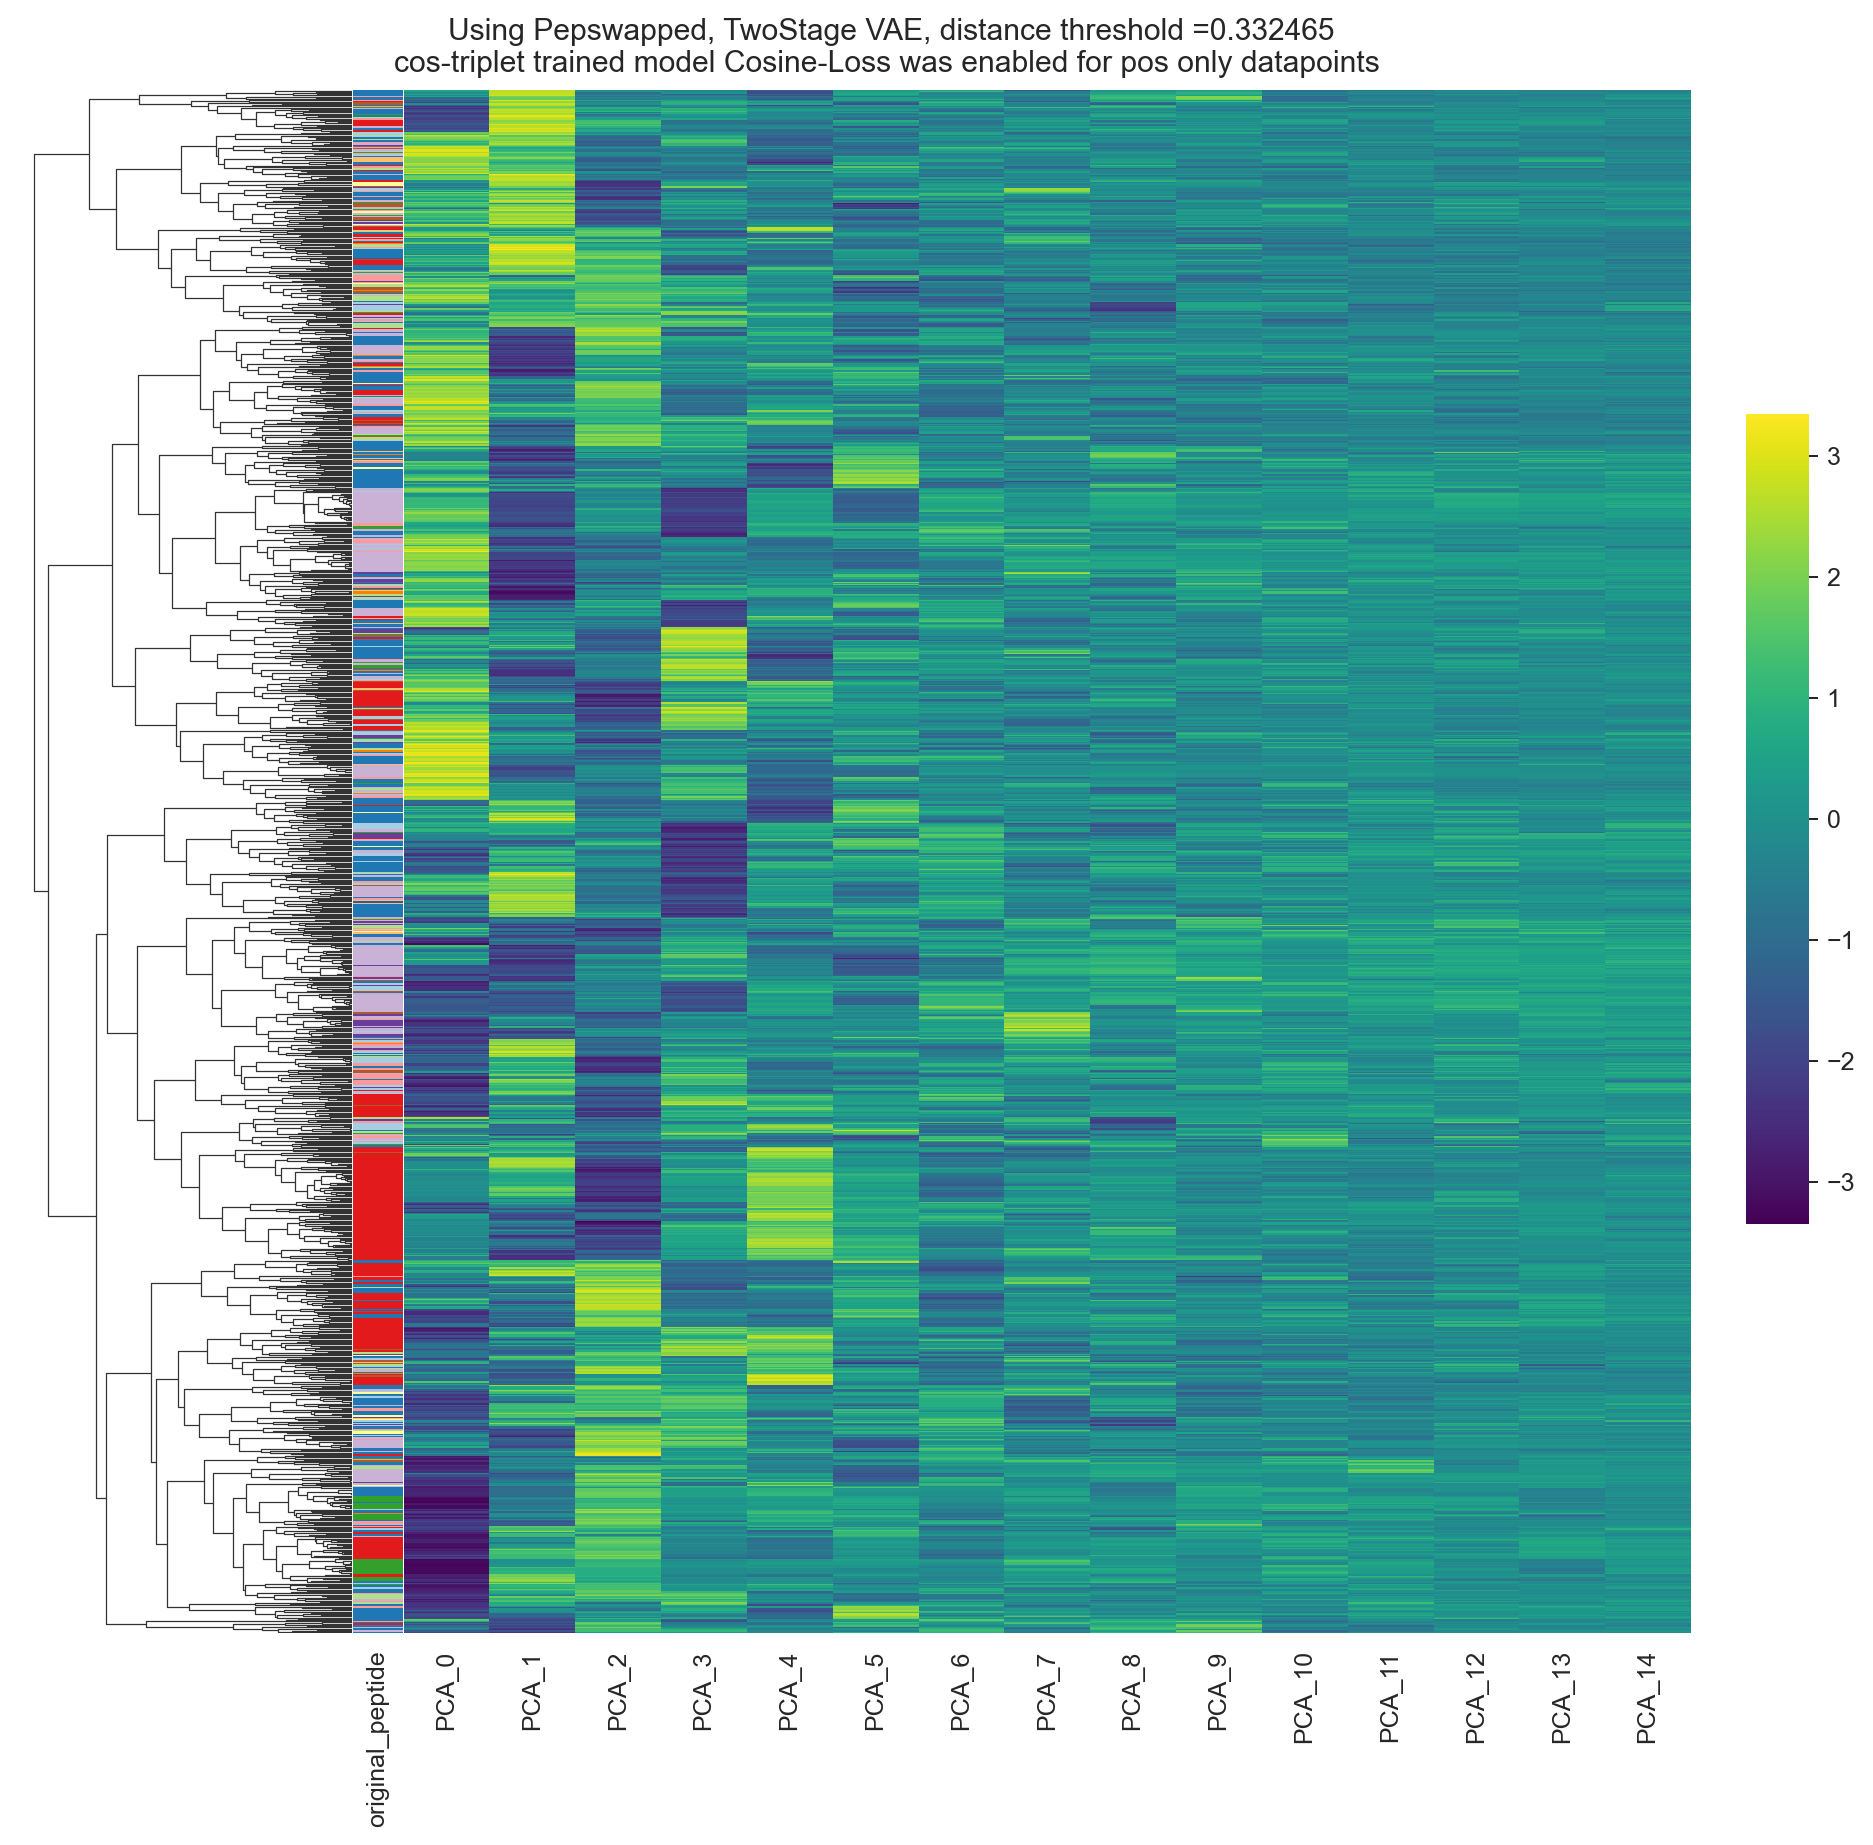

In [411]:
get_aggcluster_heatmap_plot(preds_2st_ct, linkage='average', distance_threshold=0.332465, title='Using Pepswapped, TwoStage VAE, distance threshold =0.332465'\
                            '\ncos-triplet trained model Cosine-Loss was enabled for pos only datapoints ')


In [403]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hmean
# Do for 
# preds_2st_nt
# valid_2st_nt

features = preds_2st_nt.query('partition==1')

features = features[[z for z in features.columns if z.startswith('z_')]].values
sample = valid_2st_nt.copy()

results_2st_nt = []
for linkage in ['average', 'single', 'complete']:
    for t in tqdm(np.linspace(0.06, 0.5, 500)):
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold = t, linkage=linkage)
        predicted_hc = clustering.fit_predict(sample.drop(columns=['peptide', 'original_peptide']).values)
        try:
            ch = round(ch_score(features, predicted_hc),5)
        except ValueError:
            continue
        try:
            db = round(db_score(features, predicted_hc),5)
        except ValueError:
            continue
        
        results_2st_nt.append([linkage, t, ch, db, 'hierarchical'])


results_2st_nt = pd.DataFrame(results_2st_nt, columns = ['param1', 'threshold', 'CH_score', 'DB_score', 'method'])
mms = MinMaxScaler()
results_2st_nt['CH_scaled'] = mms.fit_transform(results_2st_nt['CH_score'].values.reshape((-1,1)))
results_2st_nt['DB_scaled_inv'] = 1+2.220446e-16-mms.fit_transform(results_2st_nt['DB_score'].values.reshape((-1,1)))
results_2st_nt['hmean'] = results_2st_nt.apply(lambda x: hmean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
results_2st_nt['mean'] = results_2st_nt.apply(lambda x: np.mean([x['CH_scaled'], x['DB_scaled_inv']]), axis=1)
display(results_2st_nt.sort_values('hmean', ascending=False).head(5))
display(results_2st_nt.sort_values('mean', ascending=False).head(5))
results_2st_nt.CH_score.max(), results_2st_nt.DB_score.min()

100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.30it/s]


param1  threshold   CH_score  DB_score        method  CH_scaled  \
129  average   0.173747  190.26173   1.68112  hierarchical   0.761514   
123  average   0.168457  190.26173   1.68112  hierarchical   0.761514   
131  average   0.175511  190.26173   1.68112  hierarchical   0.761514   
130  average   0.174629  190.26173   1.68112  hierarchical   0.761514   
128  average   0.172866  190.26173   1.68112  hierarchical   0.761514   

     DB_scaled_inv     hmean      mean  
129       0.420443  0.541768  0.590978  
123       0.420443  0.541768  0.590978  
131       0.420443  0.541768  0.590978  
130       0.420443  0.541768  0.590978  
128       0.420443  0.541768  0.590978

param1  threshold   CH_score  DB_score        method  CH_scaled  \
163  average   0.203727  247.80046    1.7639  hierarchical        1.0   
156  average   0.197555  247.80046    1.7639  hierarchical        1.0   
149  average   0.191383  247.80046    1.7639  hierarchical        1.0   
150  average   0.192265  247.80046    1.7639  hierarchical        1.0   
151  average   0.193146  247.80046    1.7639  hierarchical        1.0   

     DB_scaled_inv     hmean      mean  
163       0.369367  0.539471  0.684683  
156       0.369367  0.539471  0.684683  
149       0.369367  0.539471  0.684683  
150       0.369367  0.539471  0.684683  
151       0.369367  0.539471  0.684683

(247.80046, 0.74182)

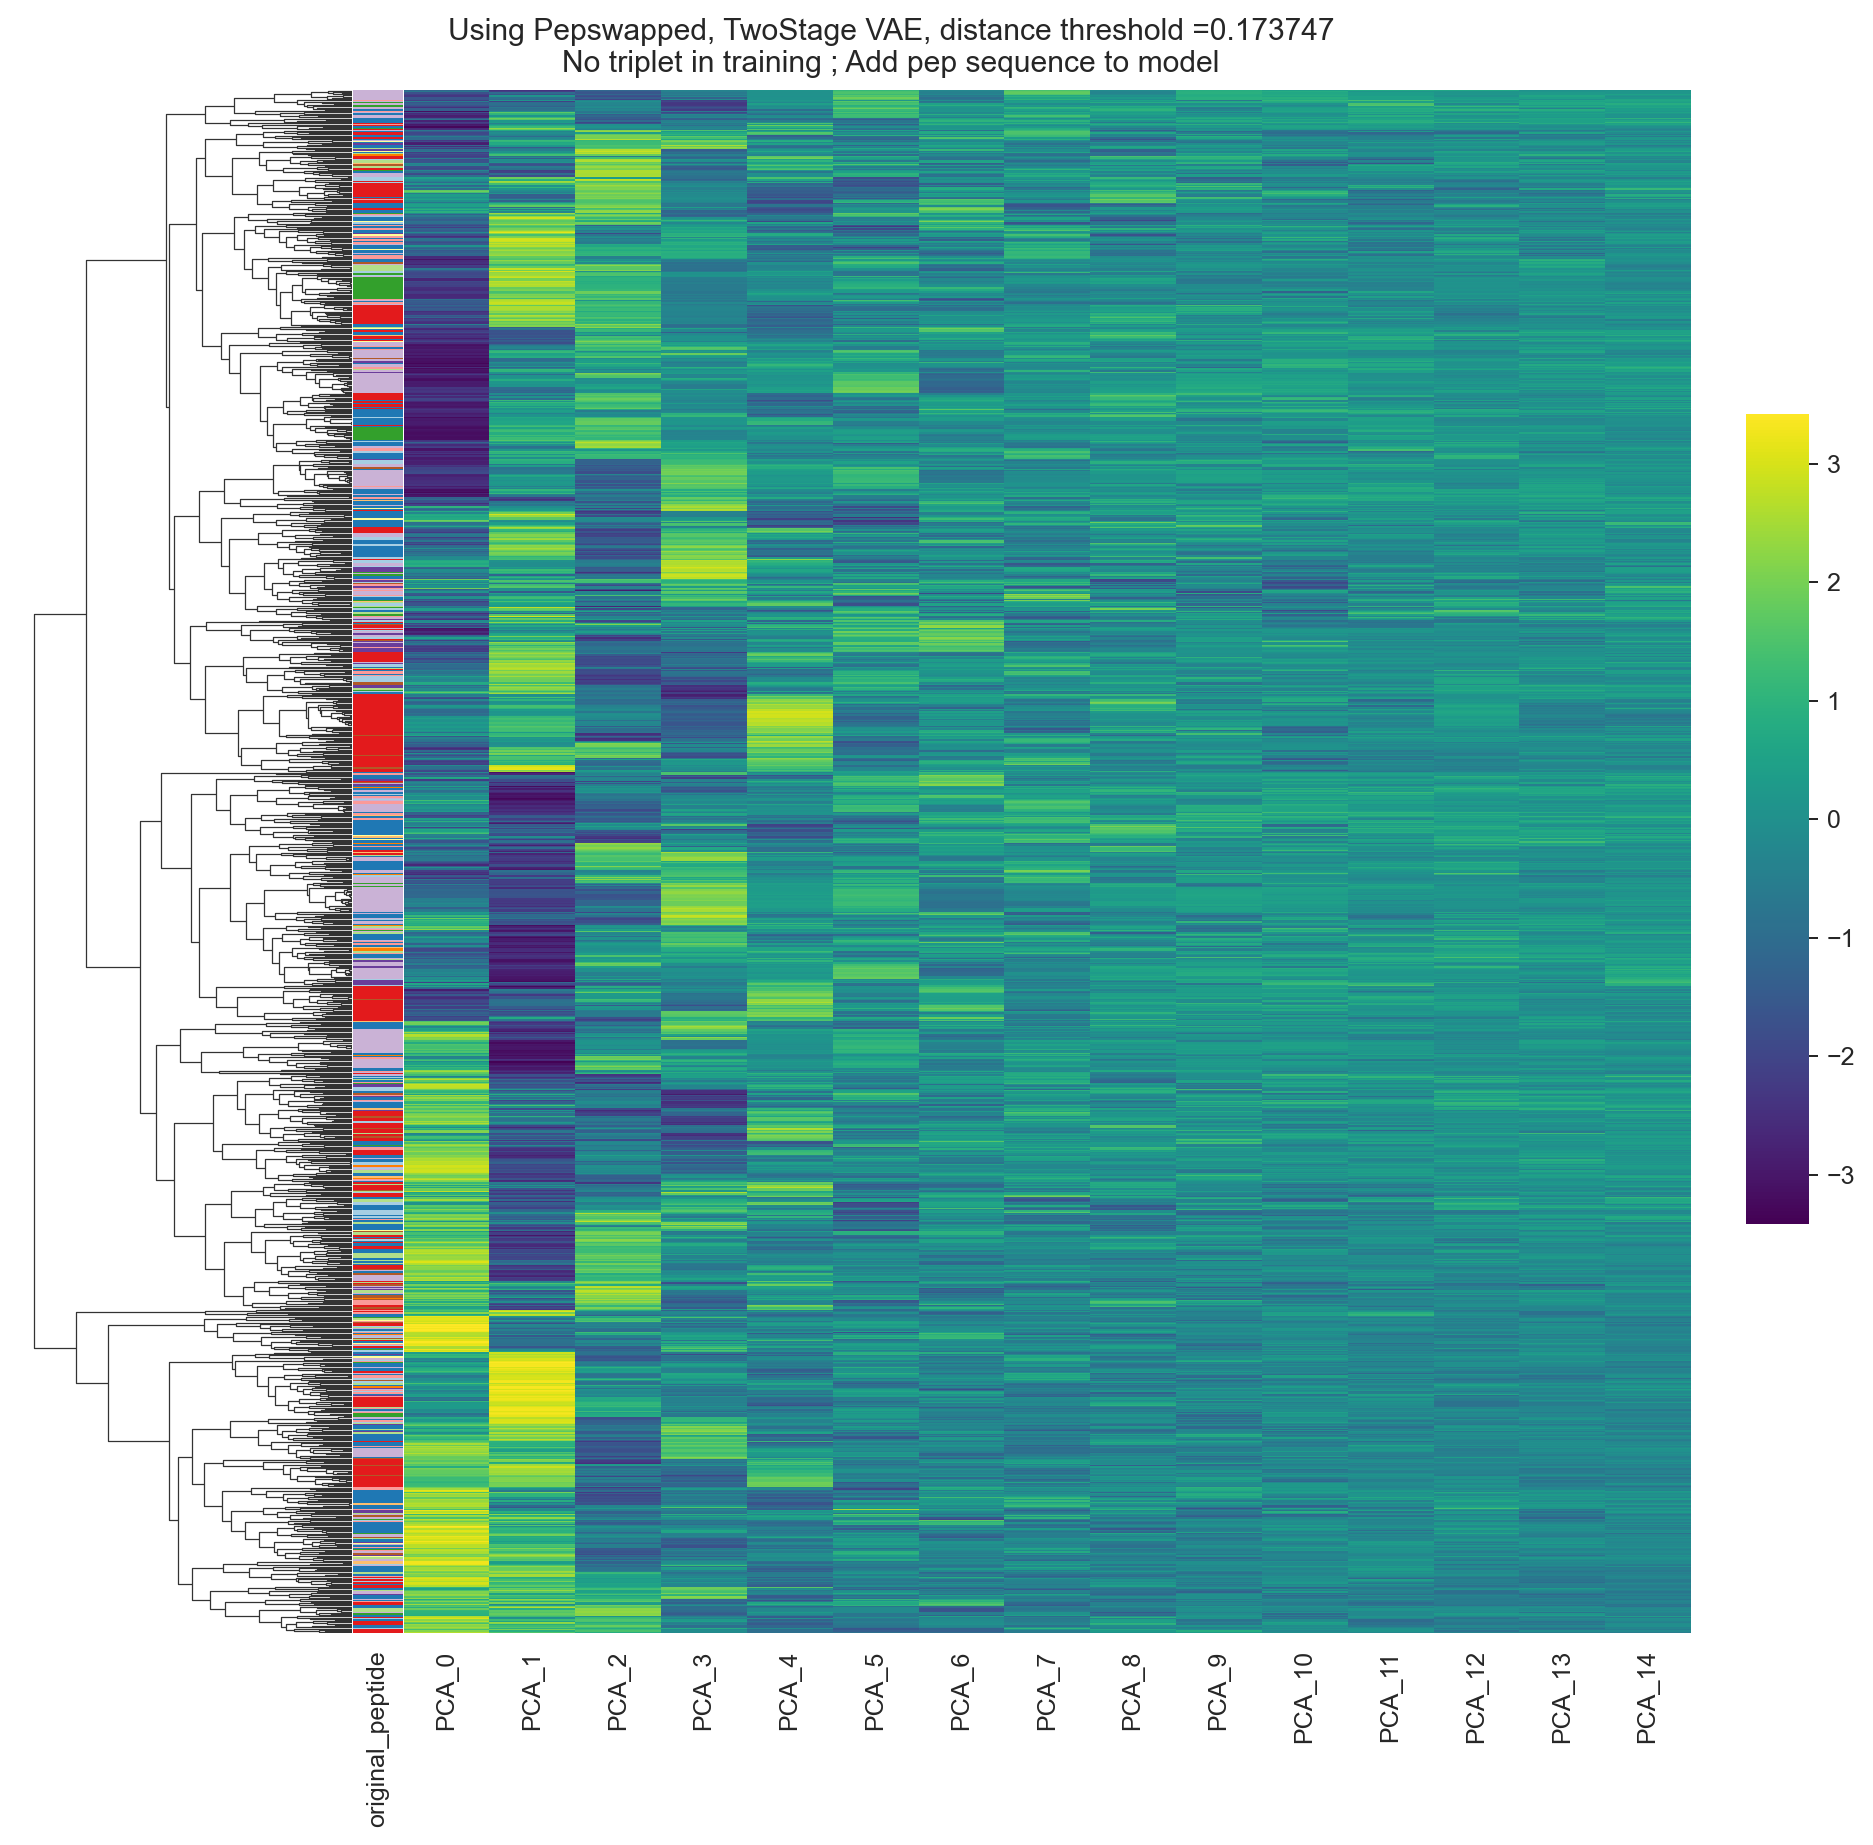

In [412]:
# 0.173747 and 0.203727

get_aggcluster_heatmap_plot(preds_2st_nt, linkage='average', distance_threshold=0.173747, title='Using Pepswapped, TwoStage VAE, distance threshold =0.173747'\
                            '\nNo triplet in training ; Add pep sequence to model')


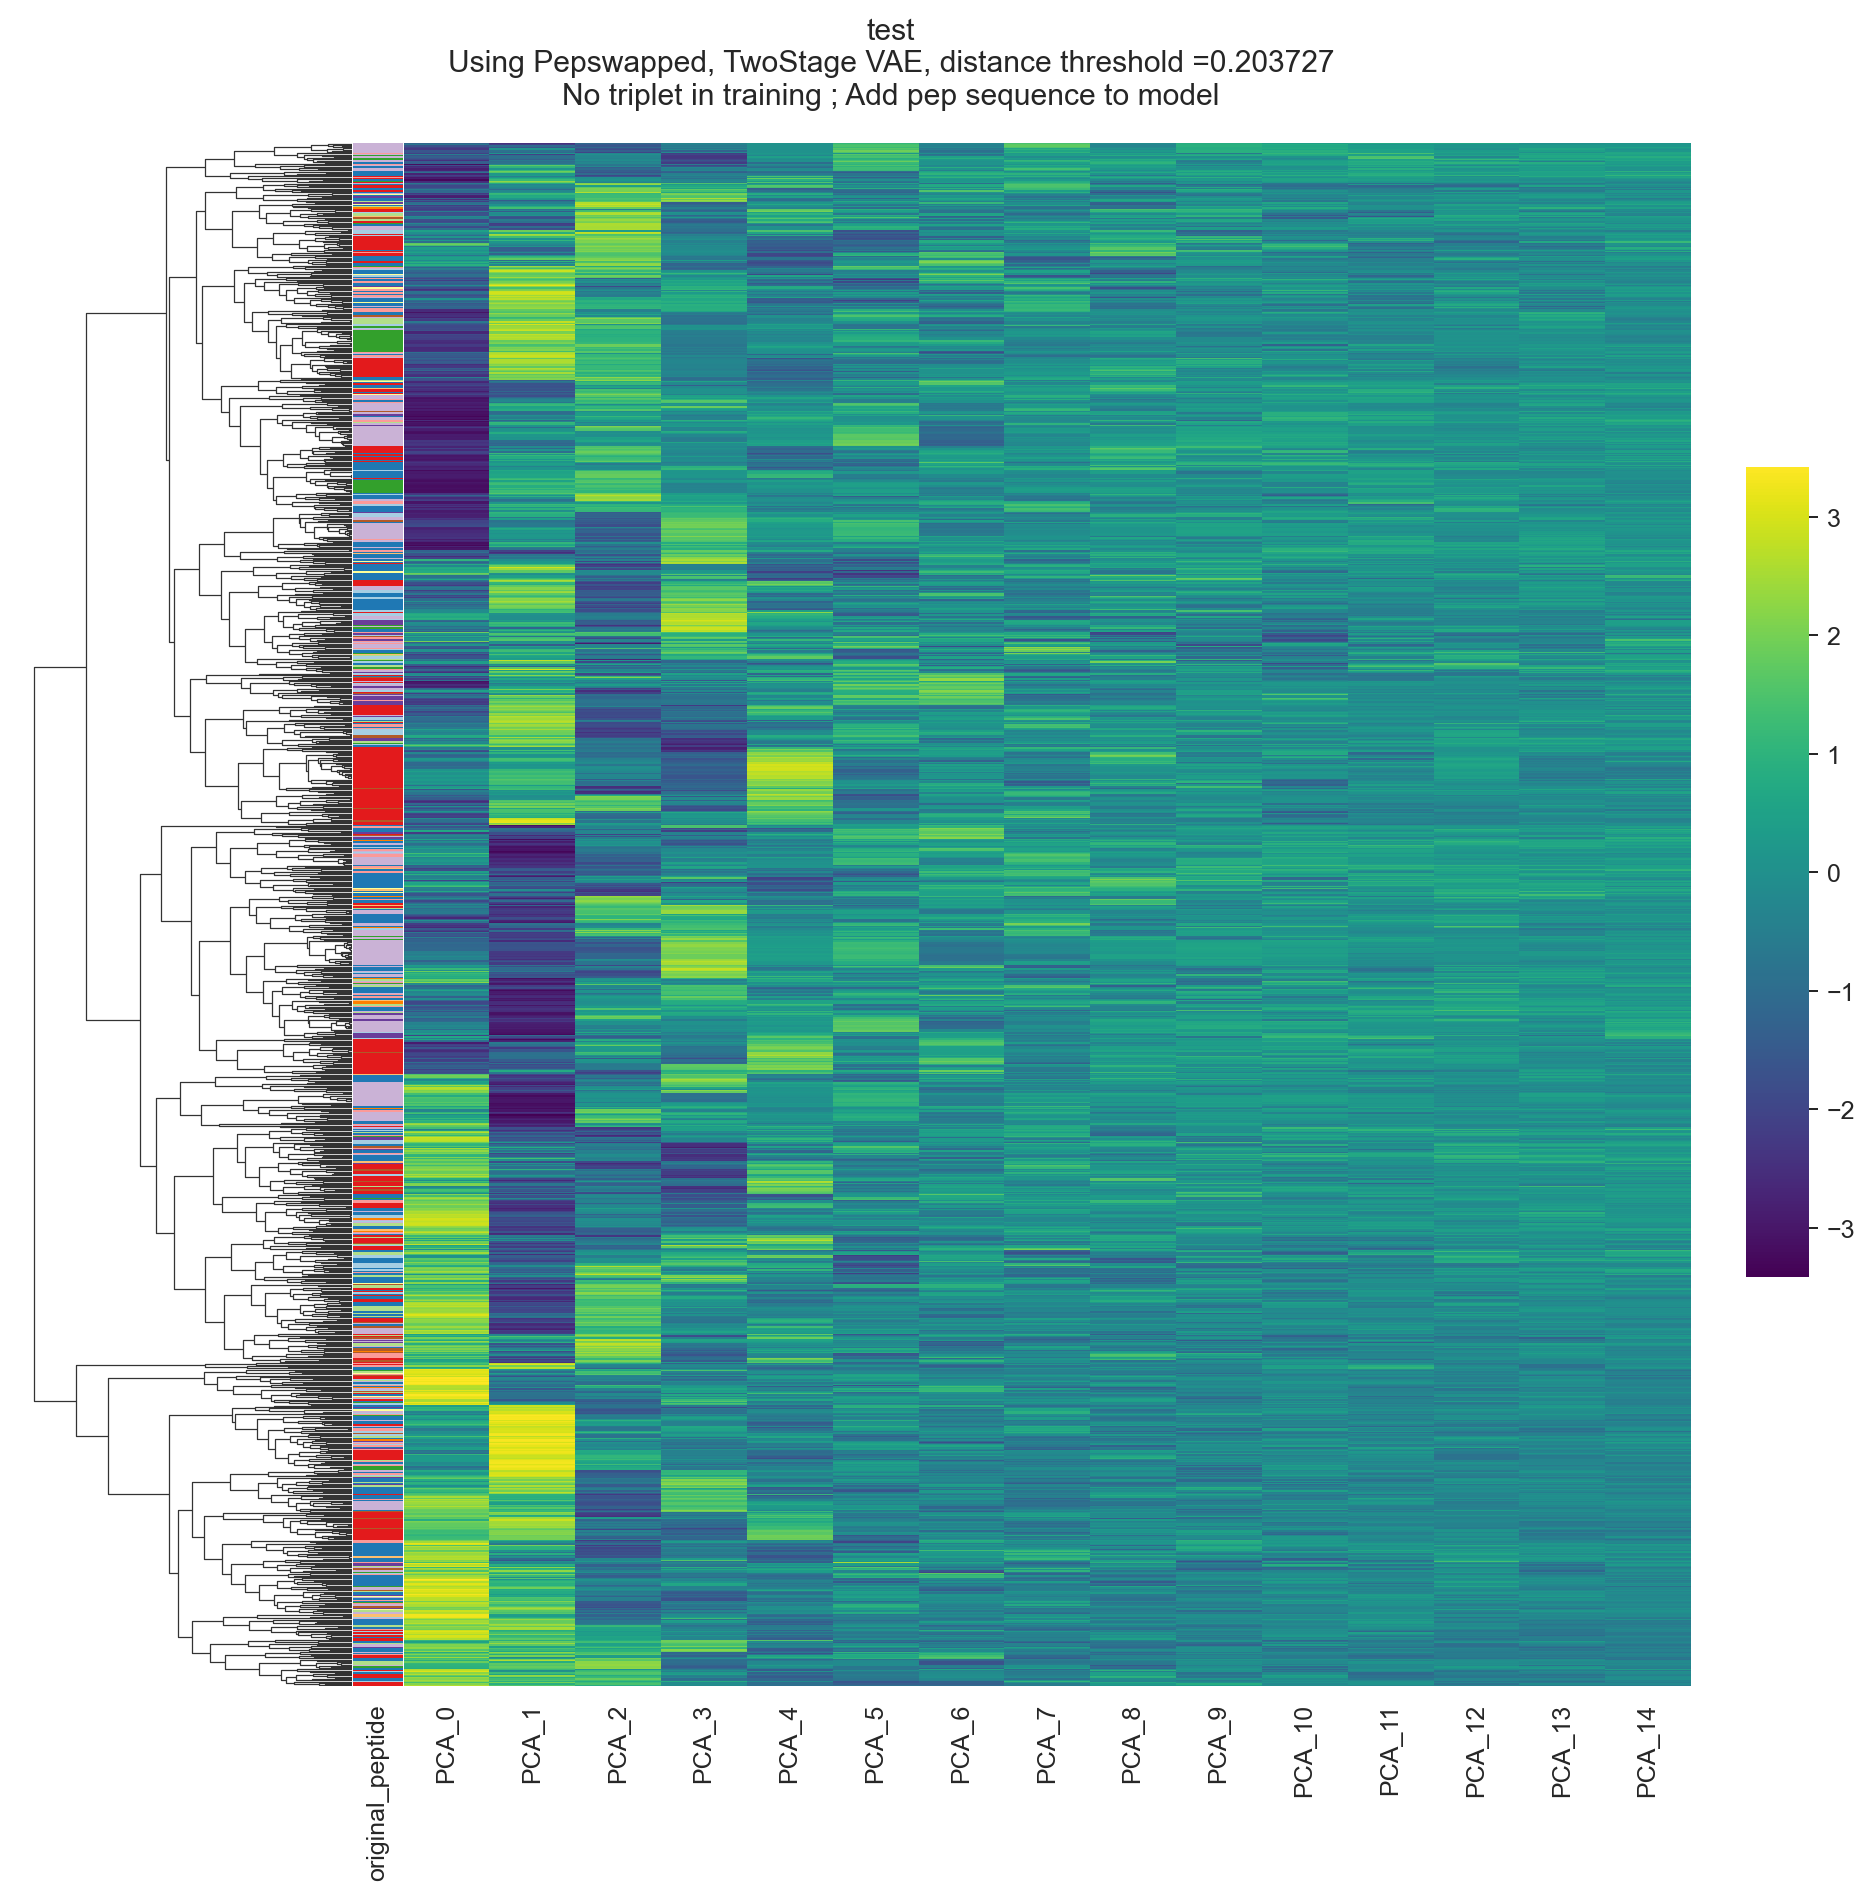

In [431]:

get_aggcluster_heatmap_plot(preds_2st_nt, linkage='average', distance_threshold=0.203727, title='test\nUsing Pepswapped, TwoStage VAE, distance threshold =0.203727'\
                            '\nNo triplet in training ; Add pep sequence to model')

## Redo and save the outputs properly



In [440]:
from sklearn.decomposition import PCA
def get_linkage_matrix(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    return linkage_matrix


def get_aggcluster_heatmap_plot(preds, linkage='average', distance_threshold=0.457675, title='', fn='file'):
    sample = preds.query('partition==1')[['A1', 'A2', 'A3', 'B1', 'B2', 'B3']+[z for z in preds_ct.columns if z.startswith('z_')]+['peptide', 'original_peptide']].sort_values('original_peptide')
    sample_dist_matrix = make_dist_matrix(sample)
    # Do agglomerative clustering with hyperparameters found earlier
    agg = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage=linkage, distance_threshold=distance_threshold)
    predicted_clusters = agg.fit_predict(sample_dist_matrix.drop(columns=['peptide','original_peptide']).values)
    linkage_matrix = get_linkage_matrix(agg)
    
    # Get a PCA of the features
    features = sample[[z for z in preds_ct.columns if z.startswith('z_')]+['peptide', 'original_peptide']]
    pca = PCA(n_components=15)
    pca_feats = pd.DataFrame(pca.fit_transform(features.drop(columns=['peptide', 'original_peptide']).values), columns = [f'PCA_{i}' for i in range(pca.n_components_)])
    # Create the colour scheme
    features = features.rename(columns={'original_peptide':'label'})
    labels = features.pop('label')
    row_colors = {k:v for k,v in zip(labels.unique(), sns.color_palette('Paired', 26))}
    mapped_colors = labels.map(row_colors).reset_index(drop=True)
    
    g = sns.clustermap(pca_feats, col_cluster=False, row_linkage=linkage_matrix, col_linkage=None, row_colors=mapped_colors, cbar_pos=(.975, .35, .035, .45),
                   label=True, cmap = 'viridis', z_score=0, dendrogram_ratio=(0.2, 0))
    fig = g.fig
    ax = g.ax_heatmap
    ax.set_yticklabels([])
    ax.set_yticks([])
    fig.suptitle(title, y=1.05)
    g.savefig(f'{fn}.png', dpi=180)

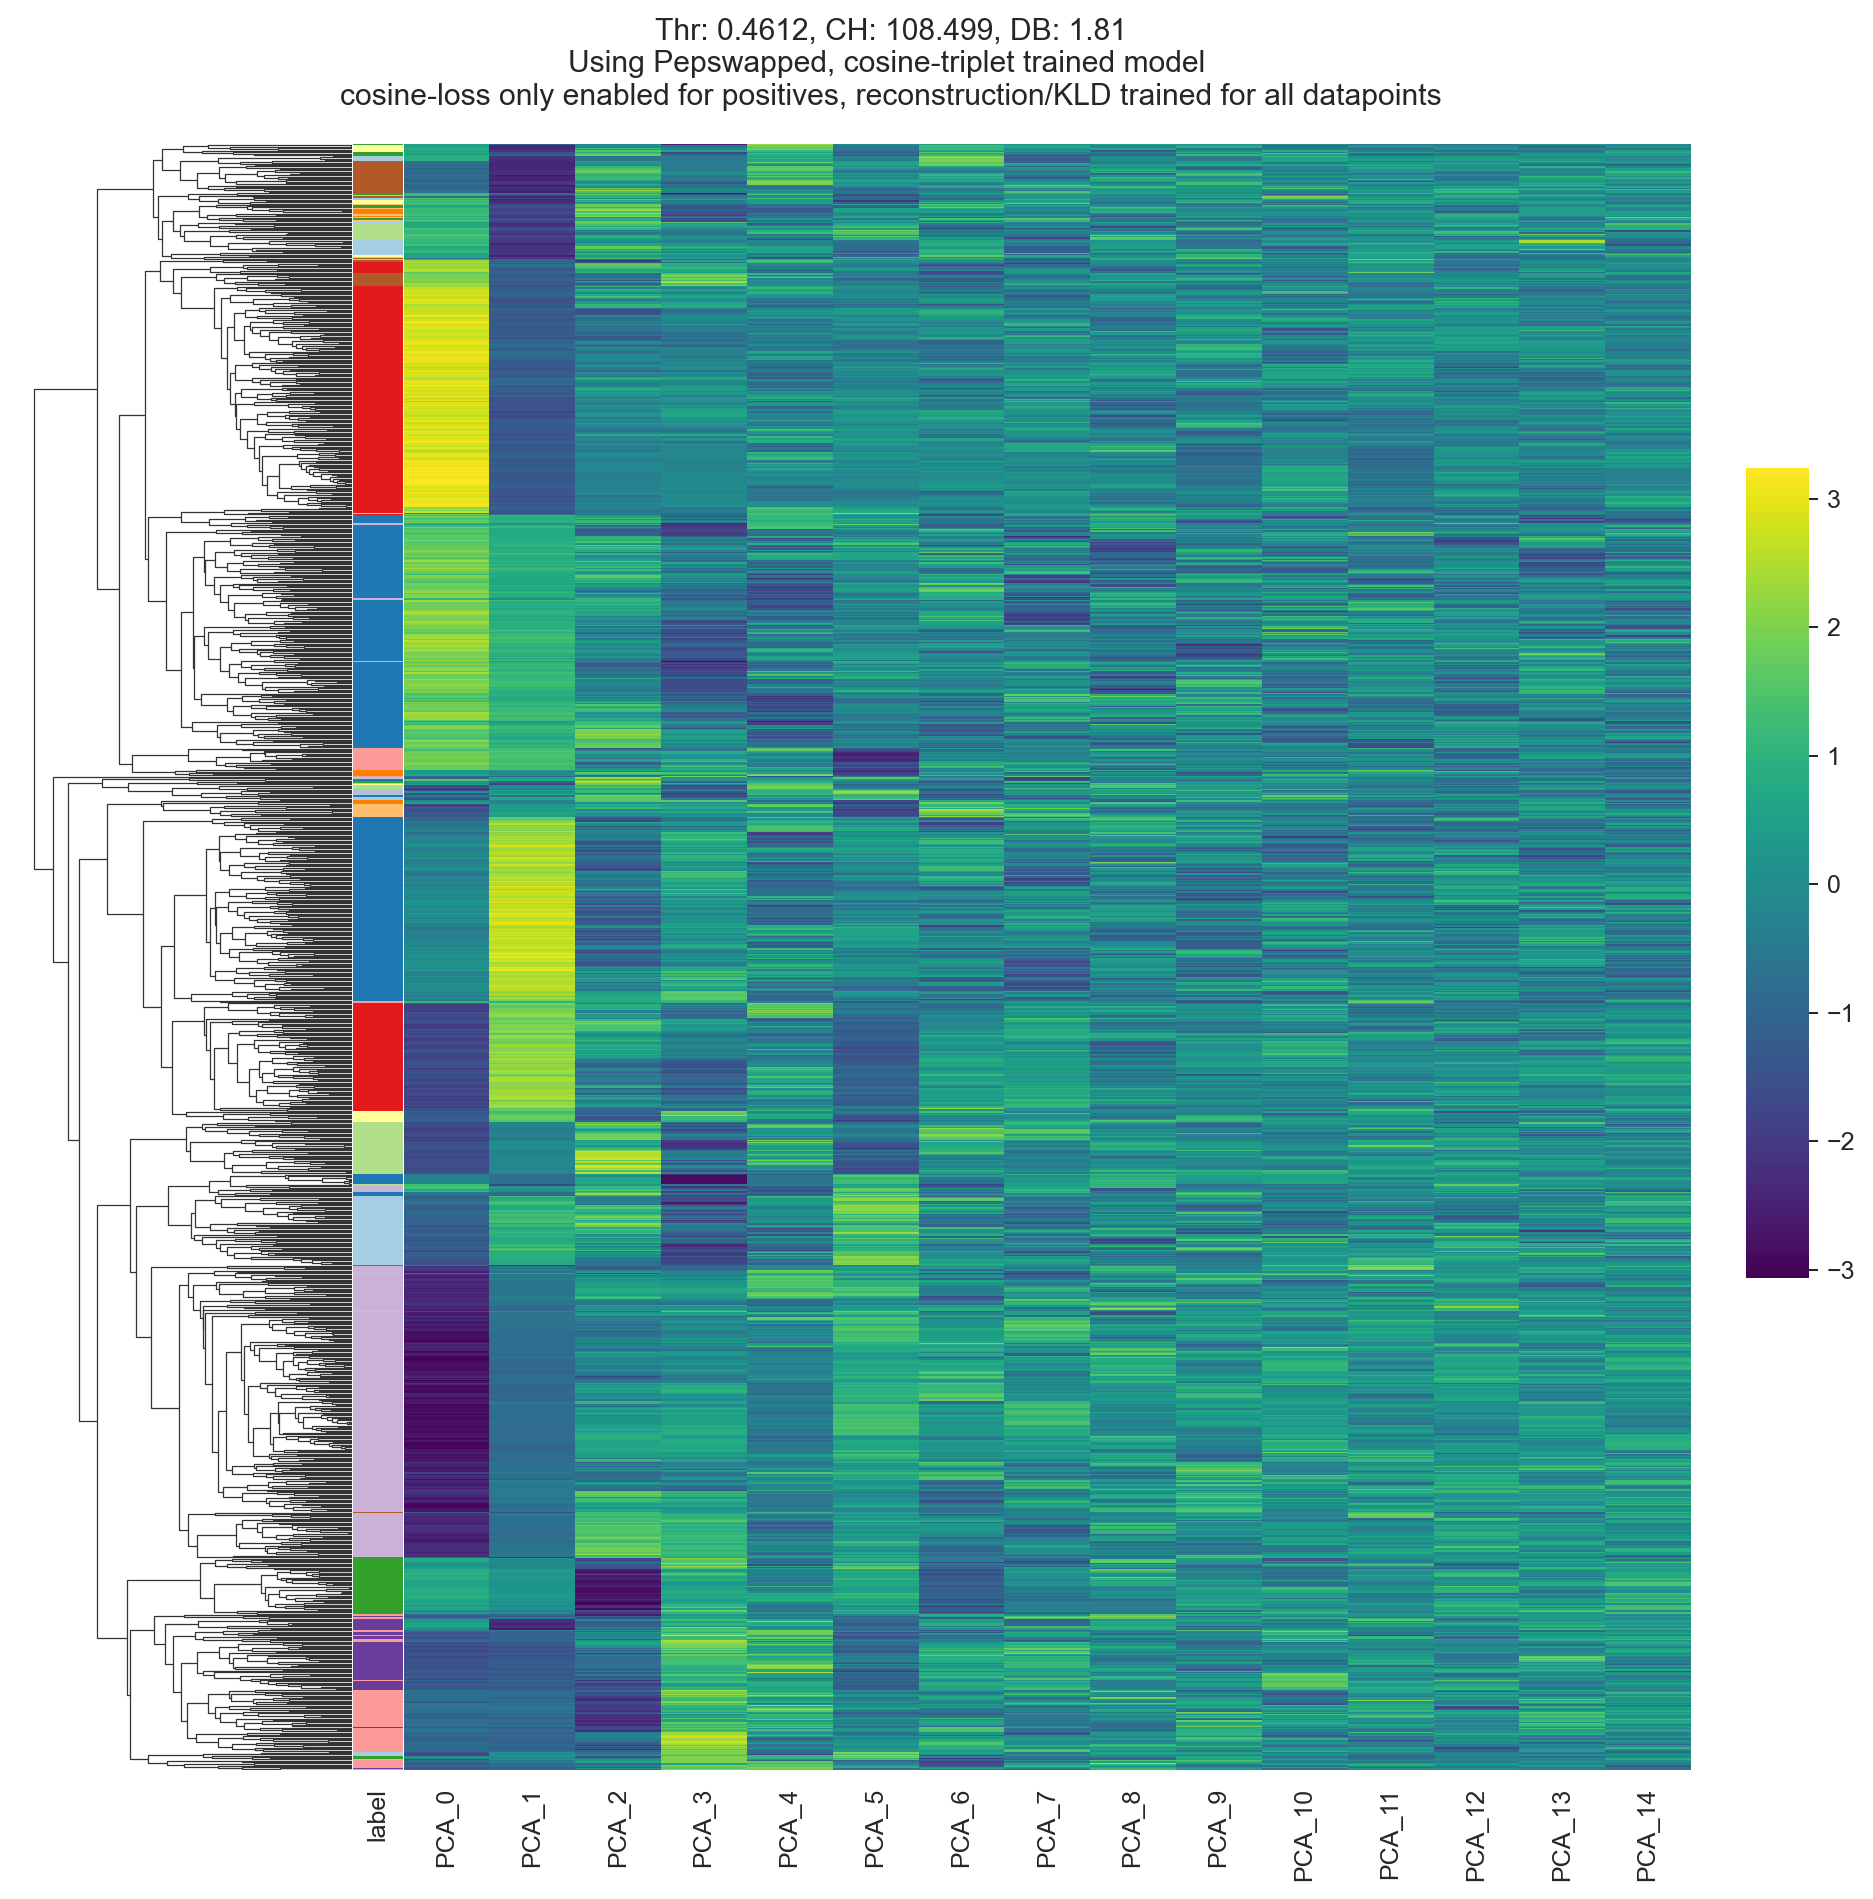

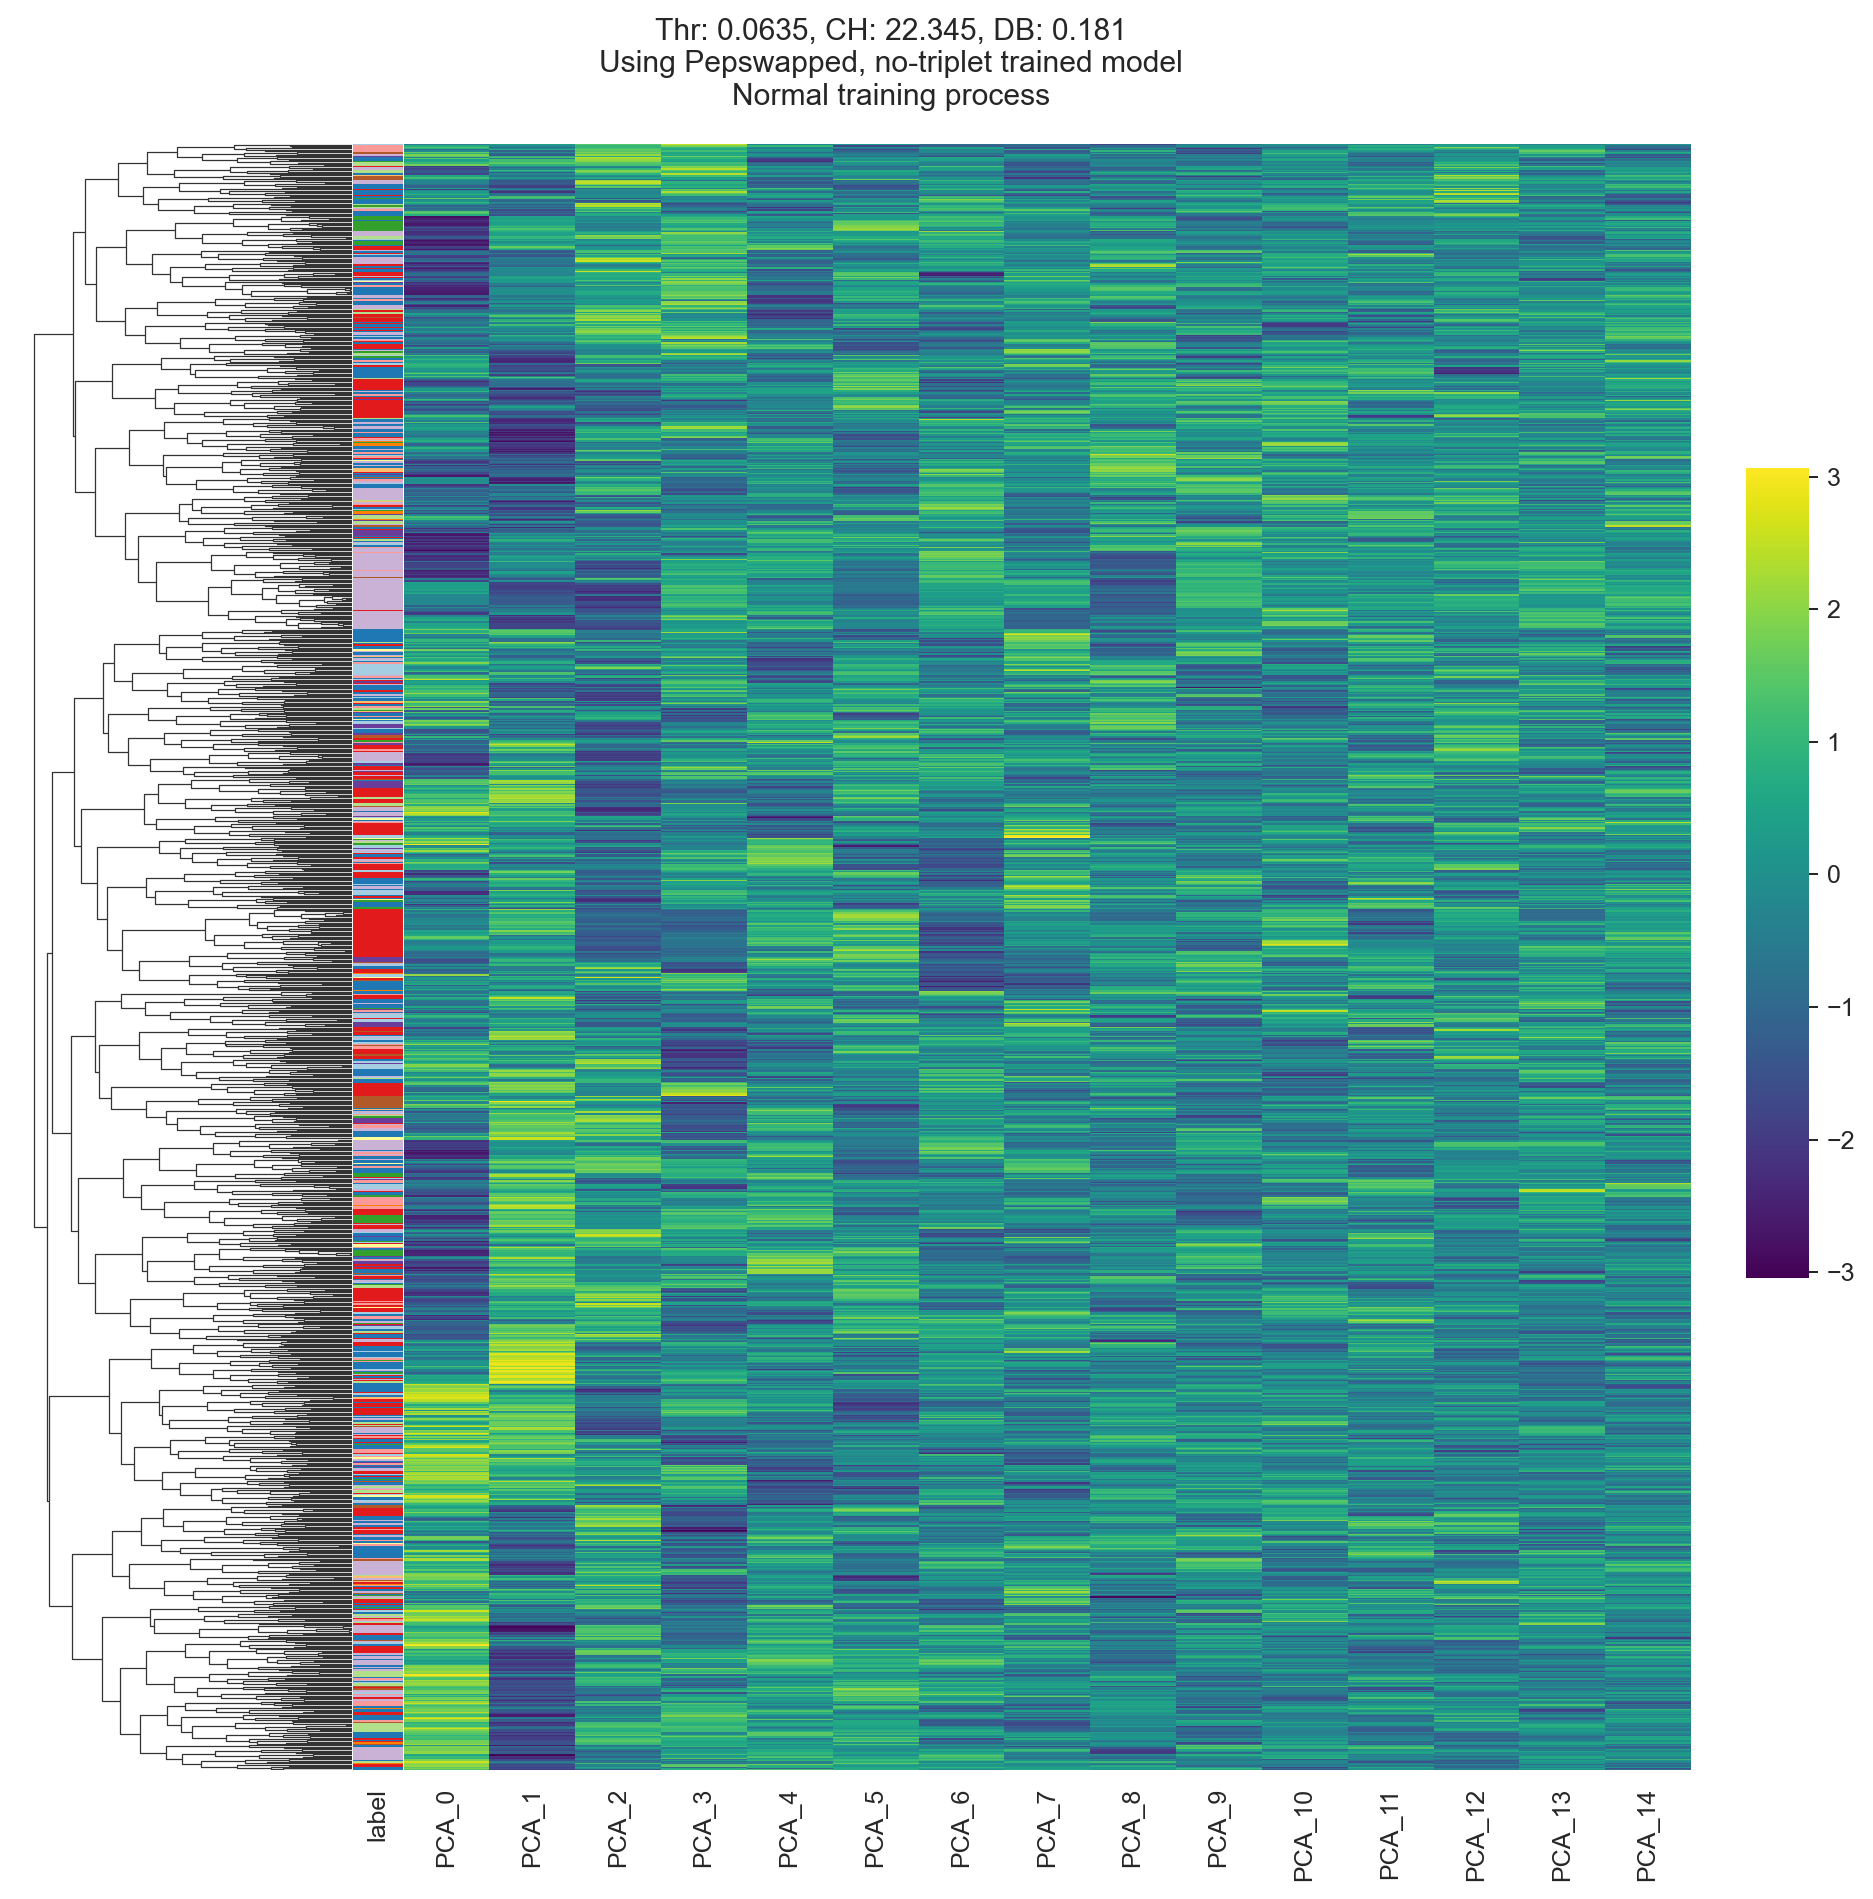

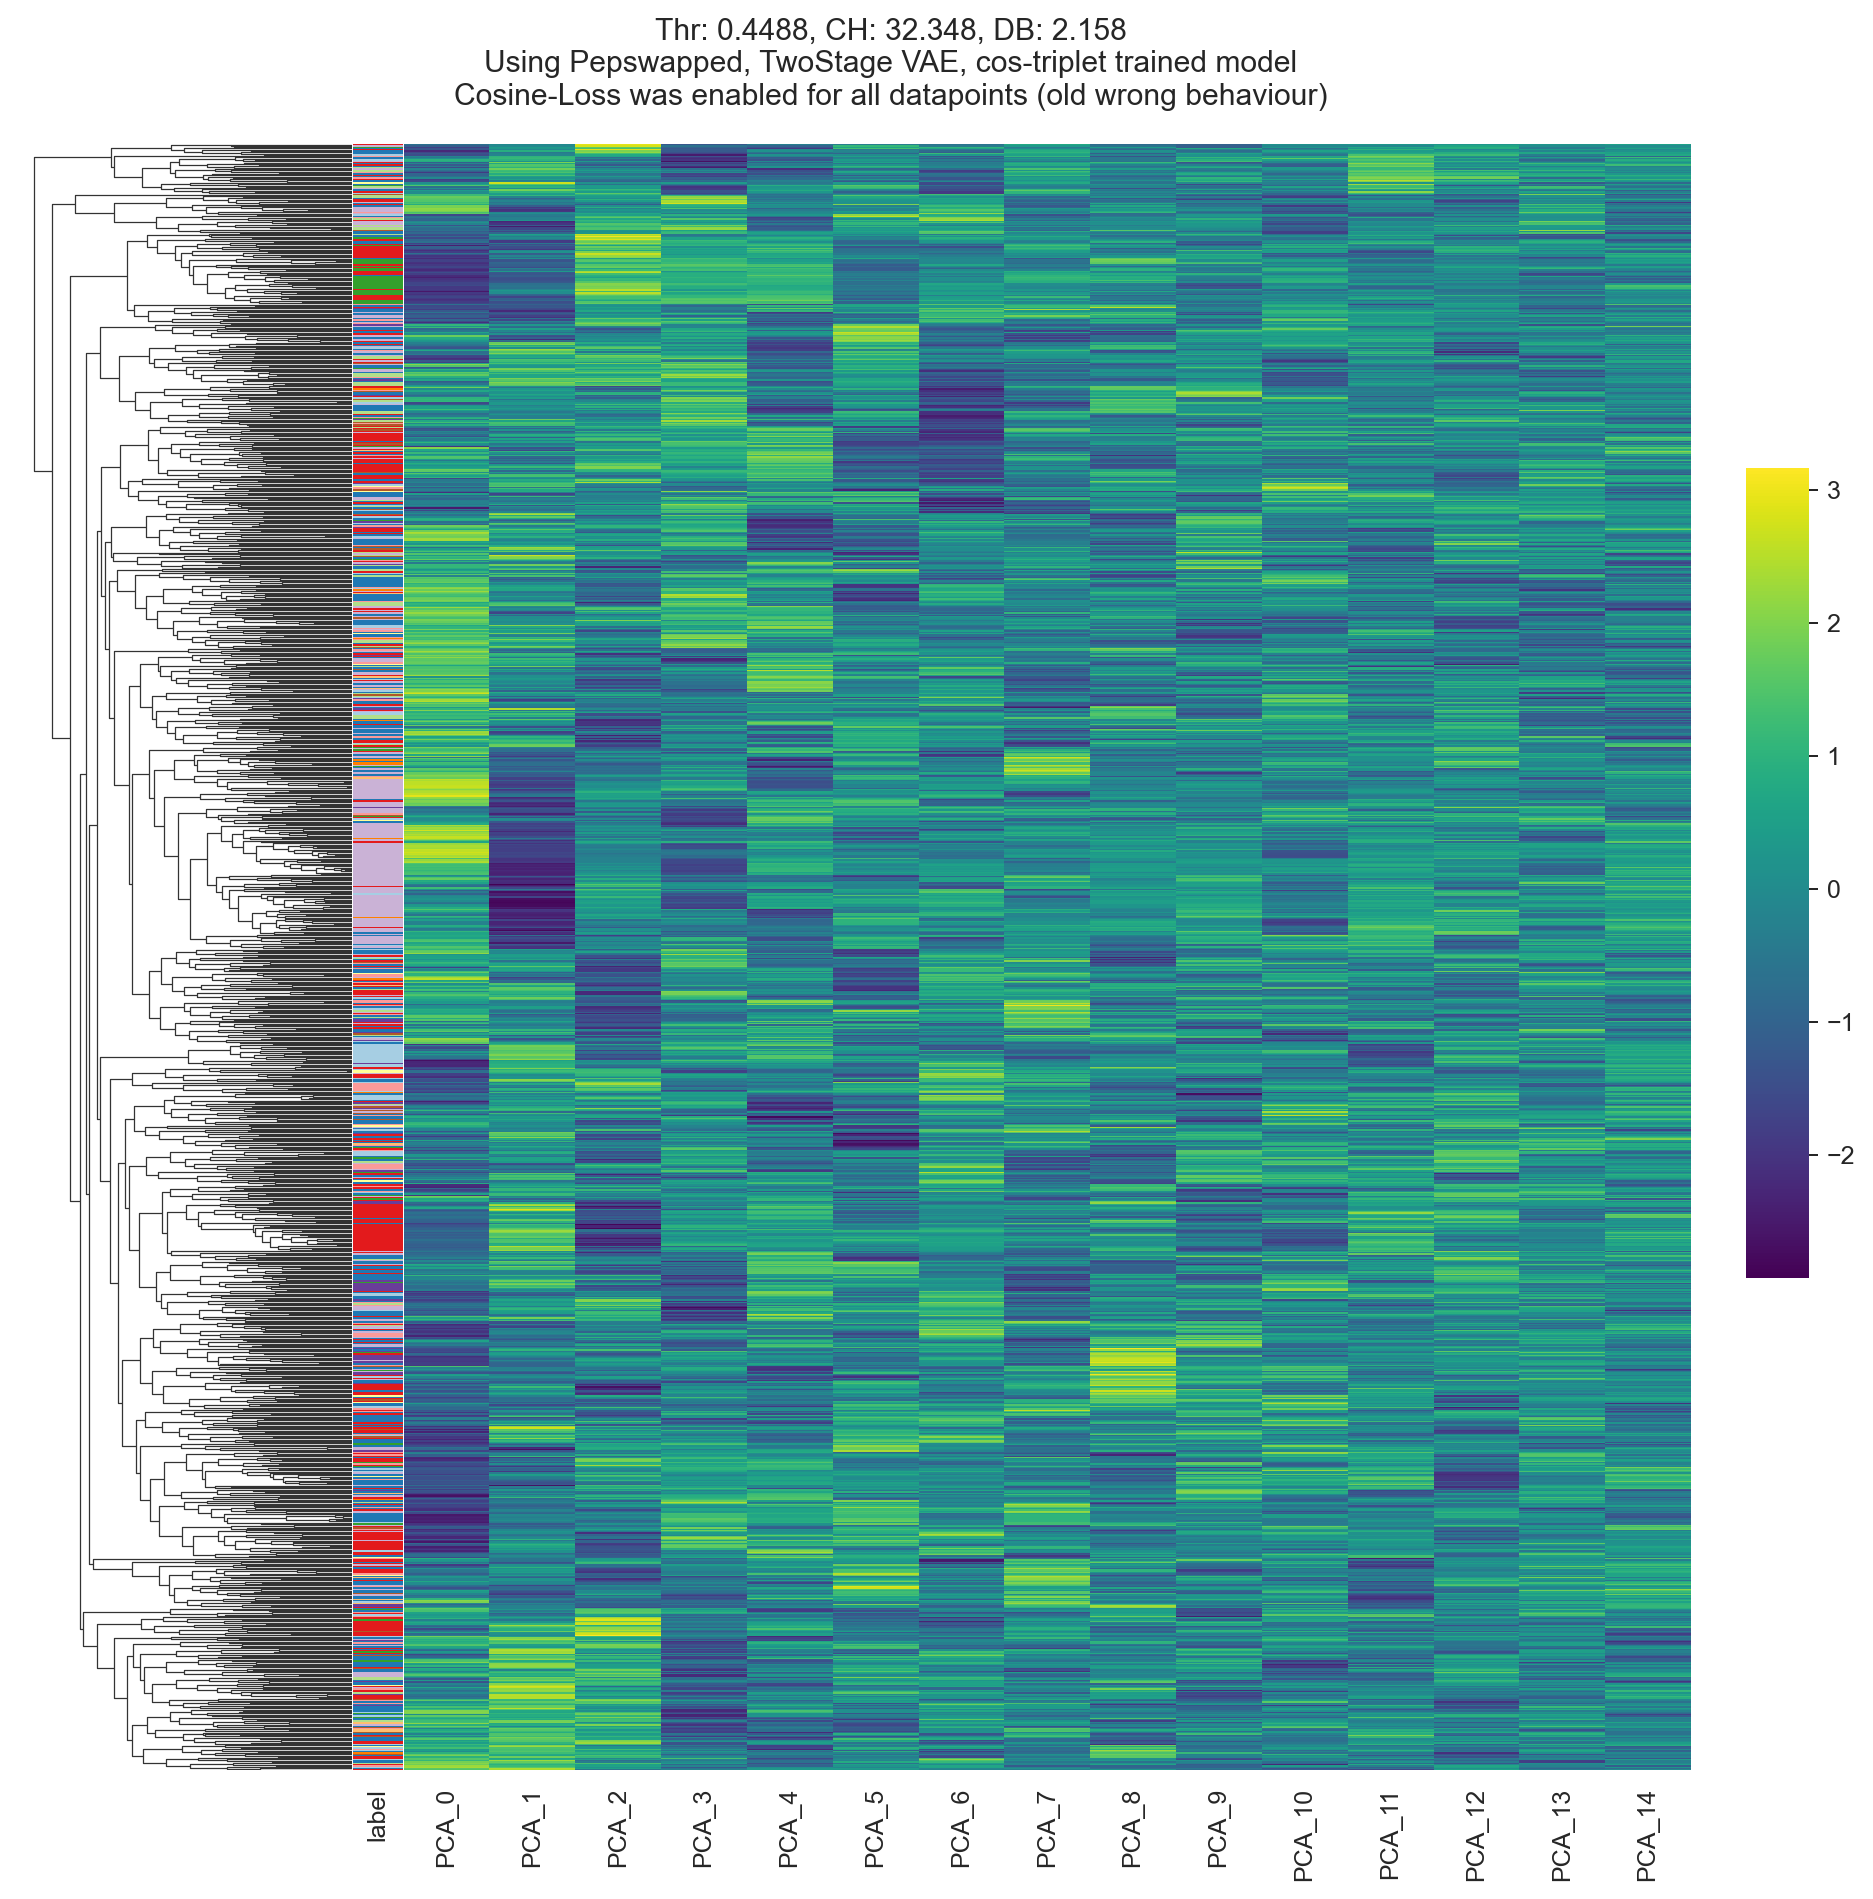

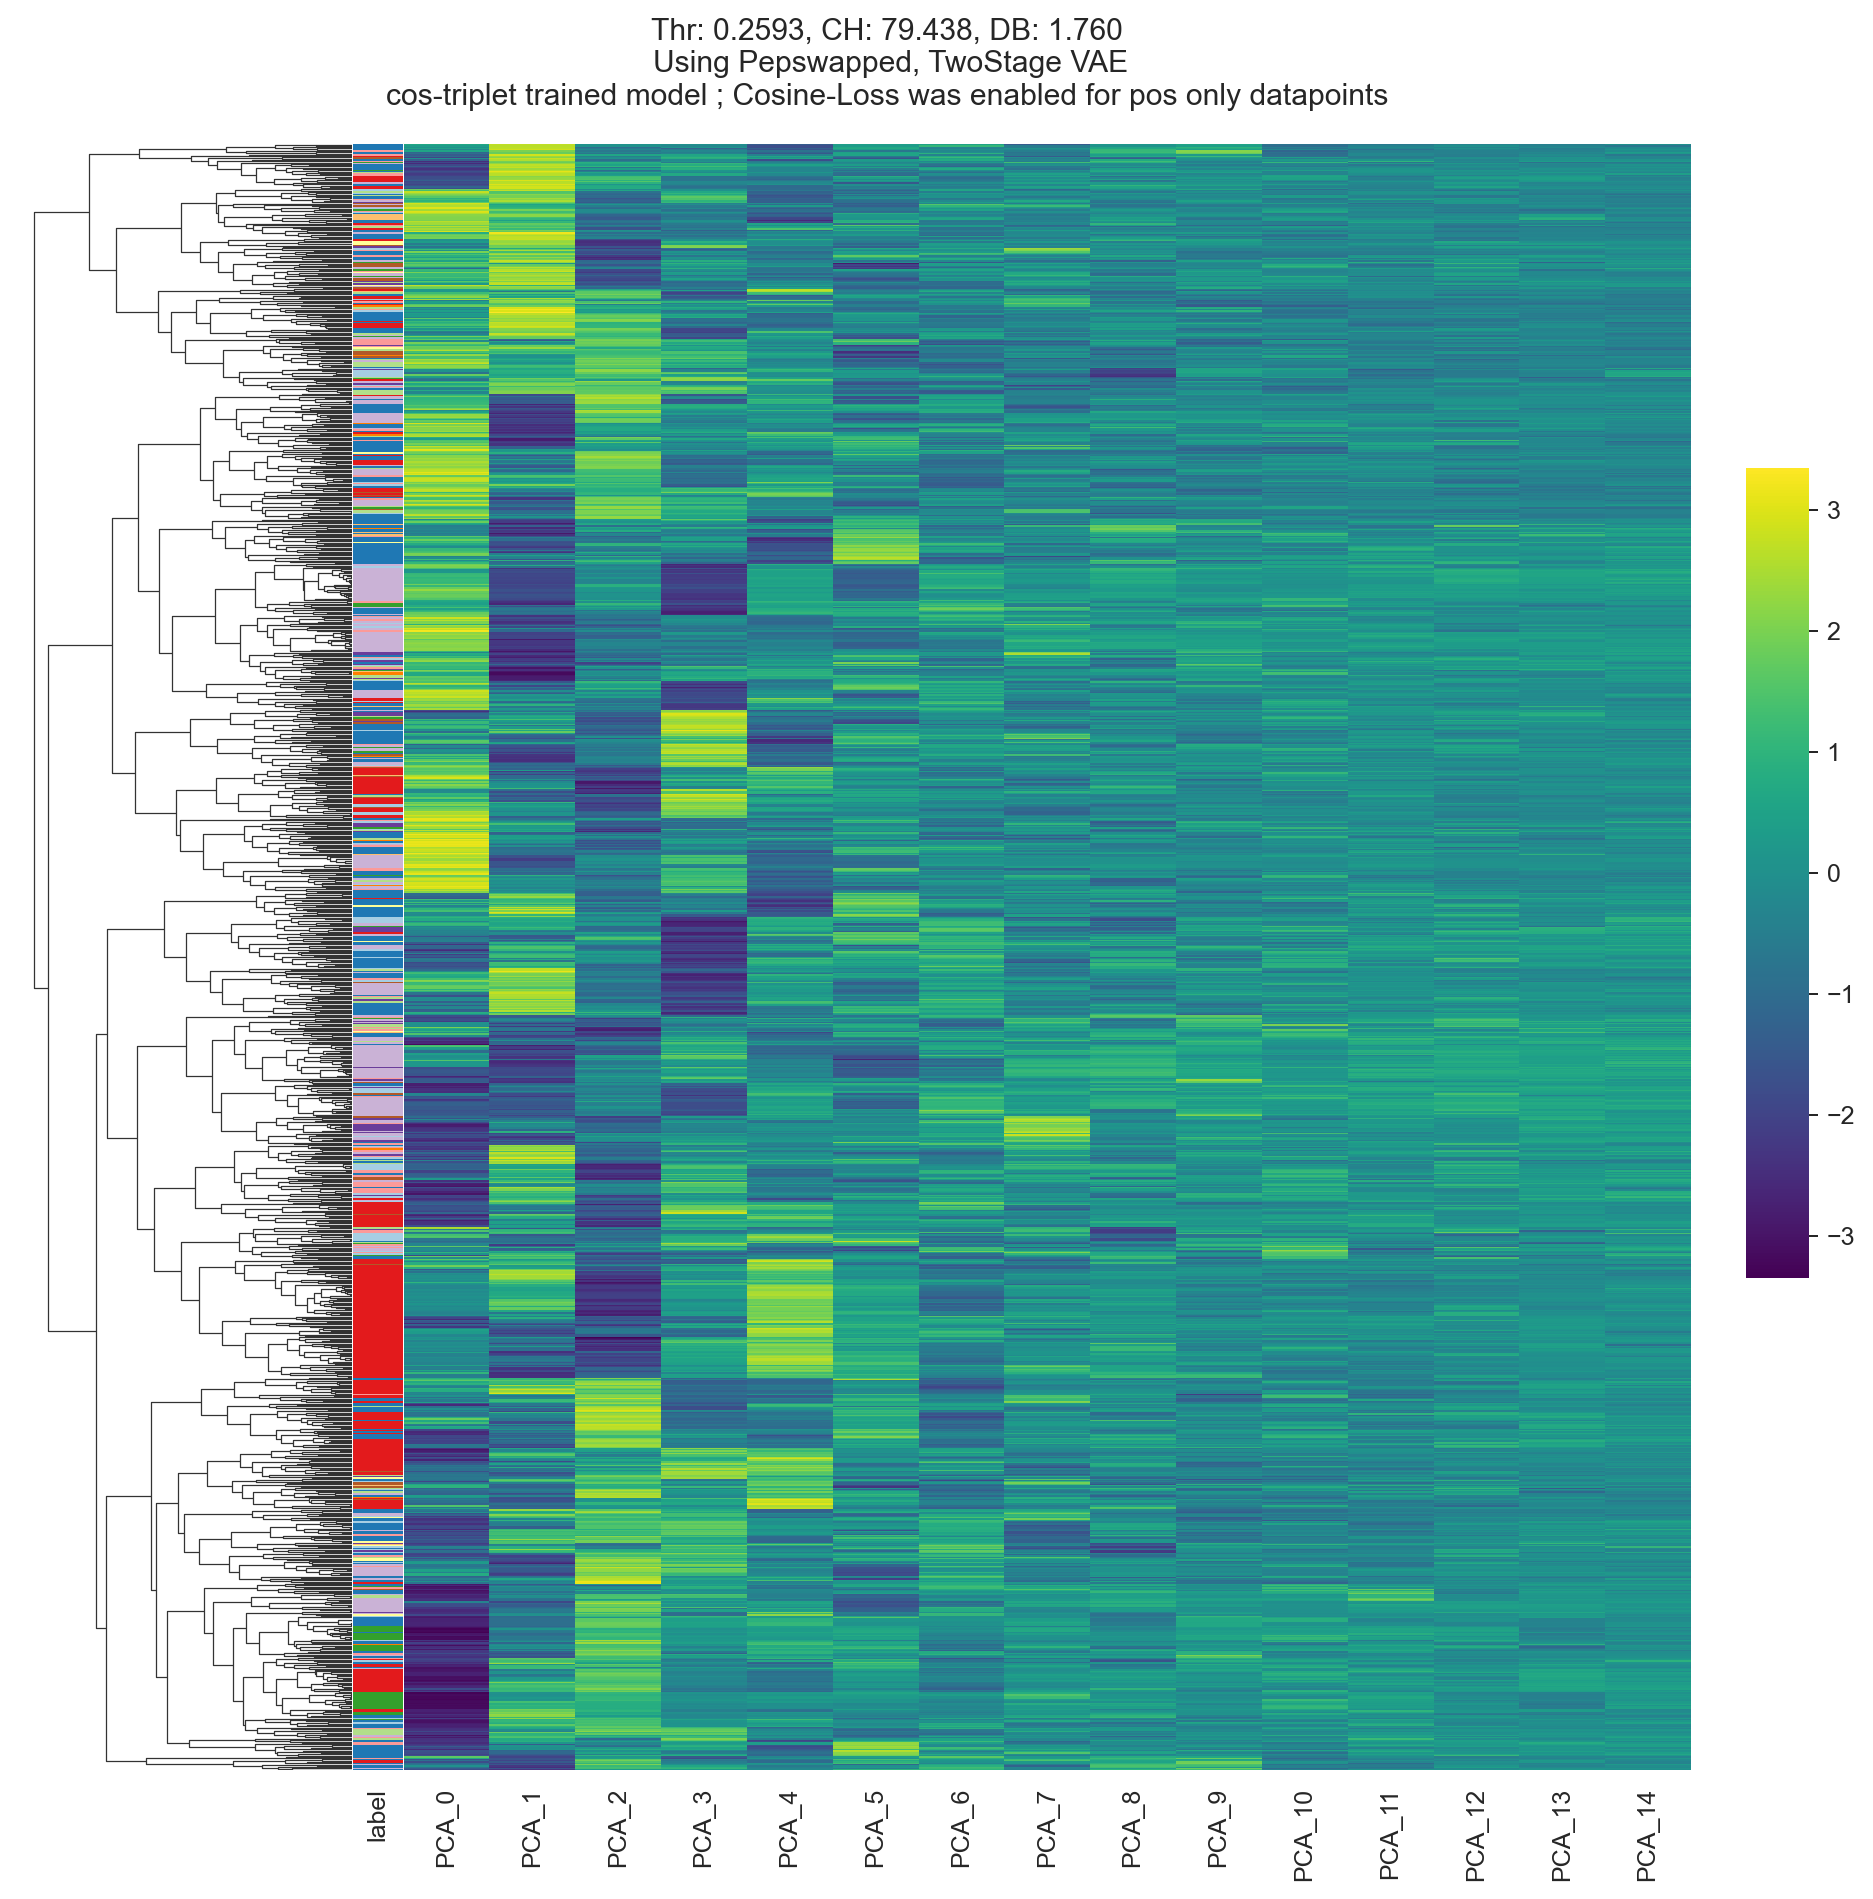

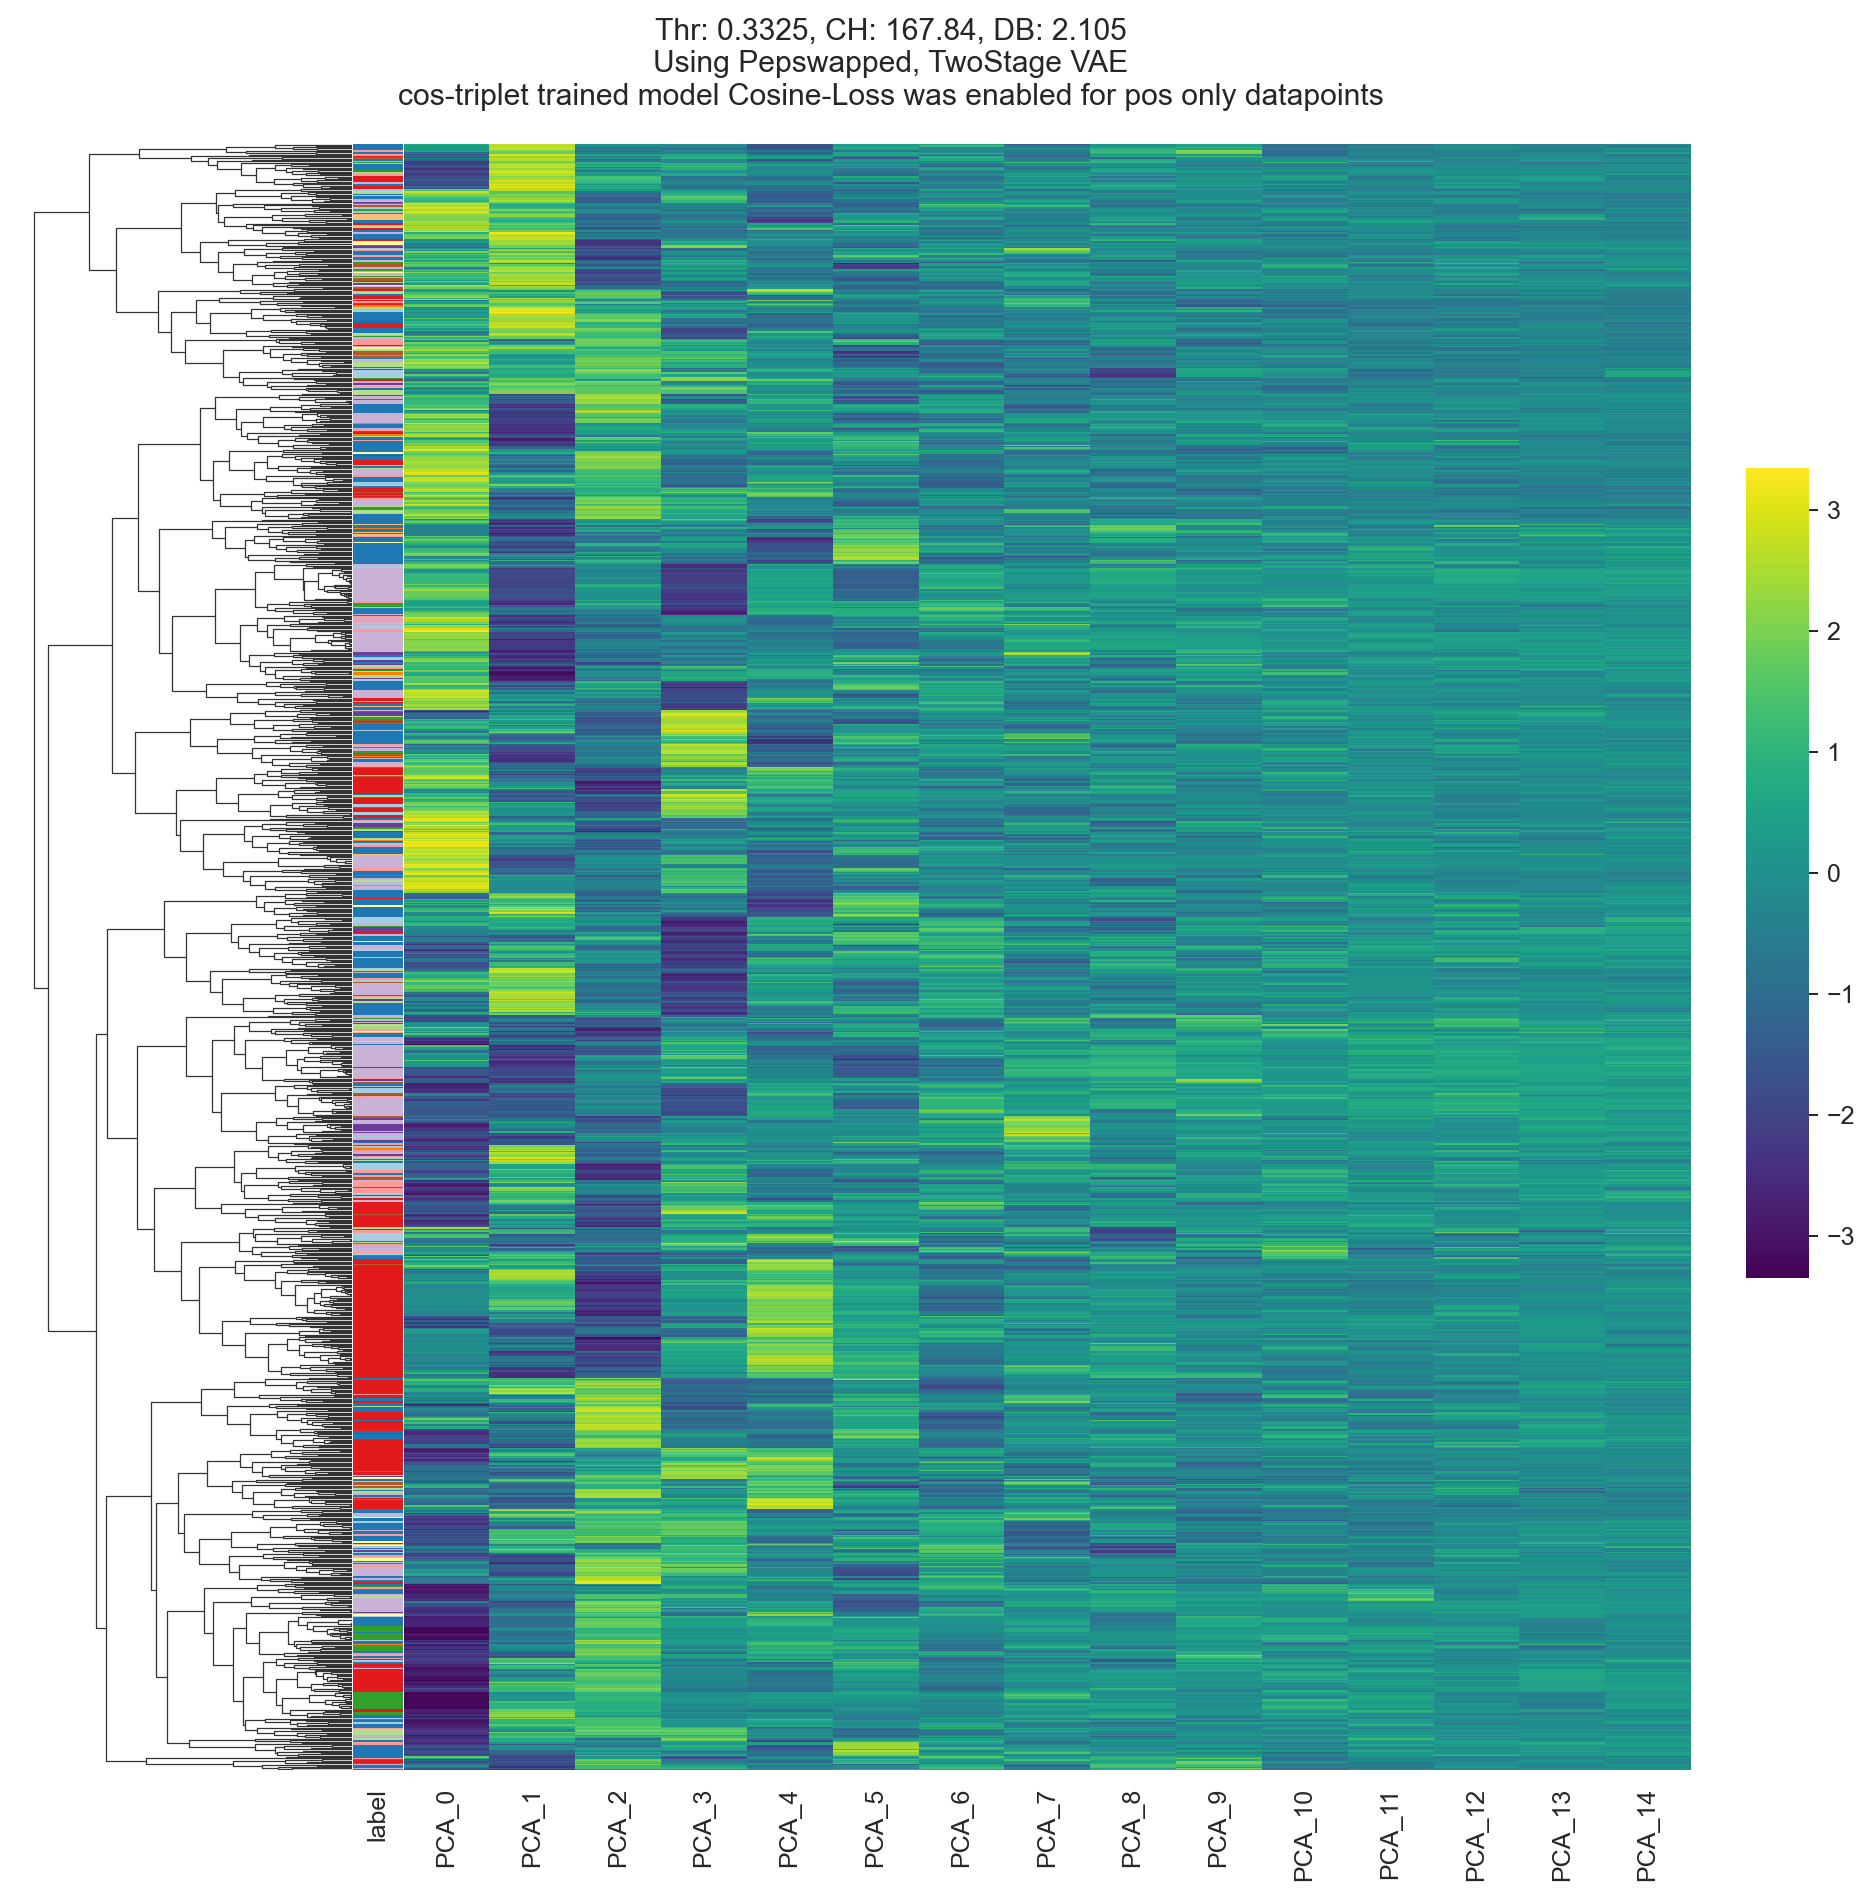

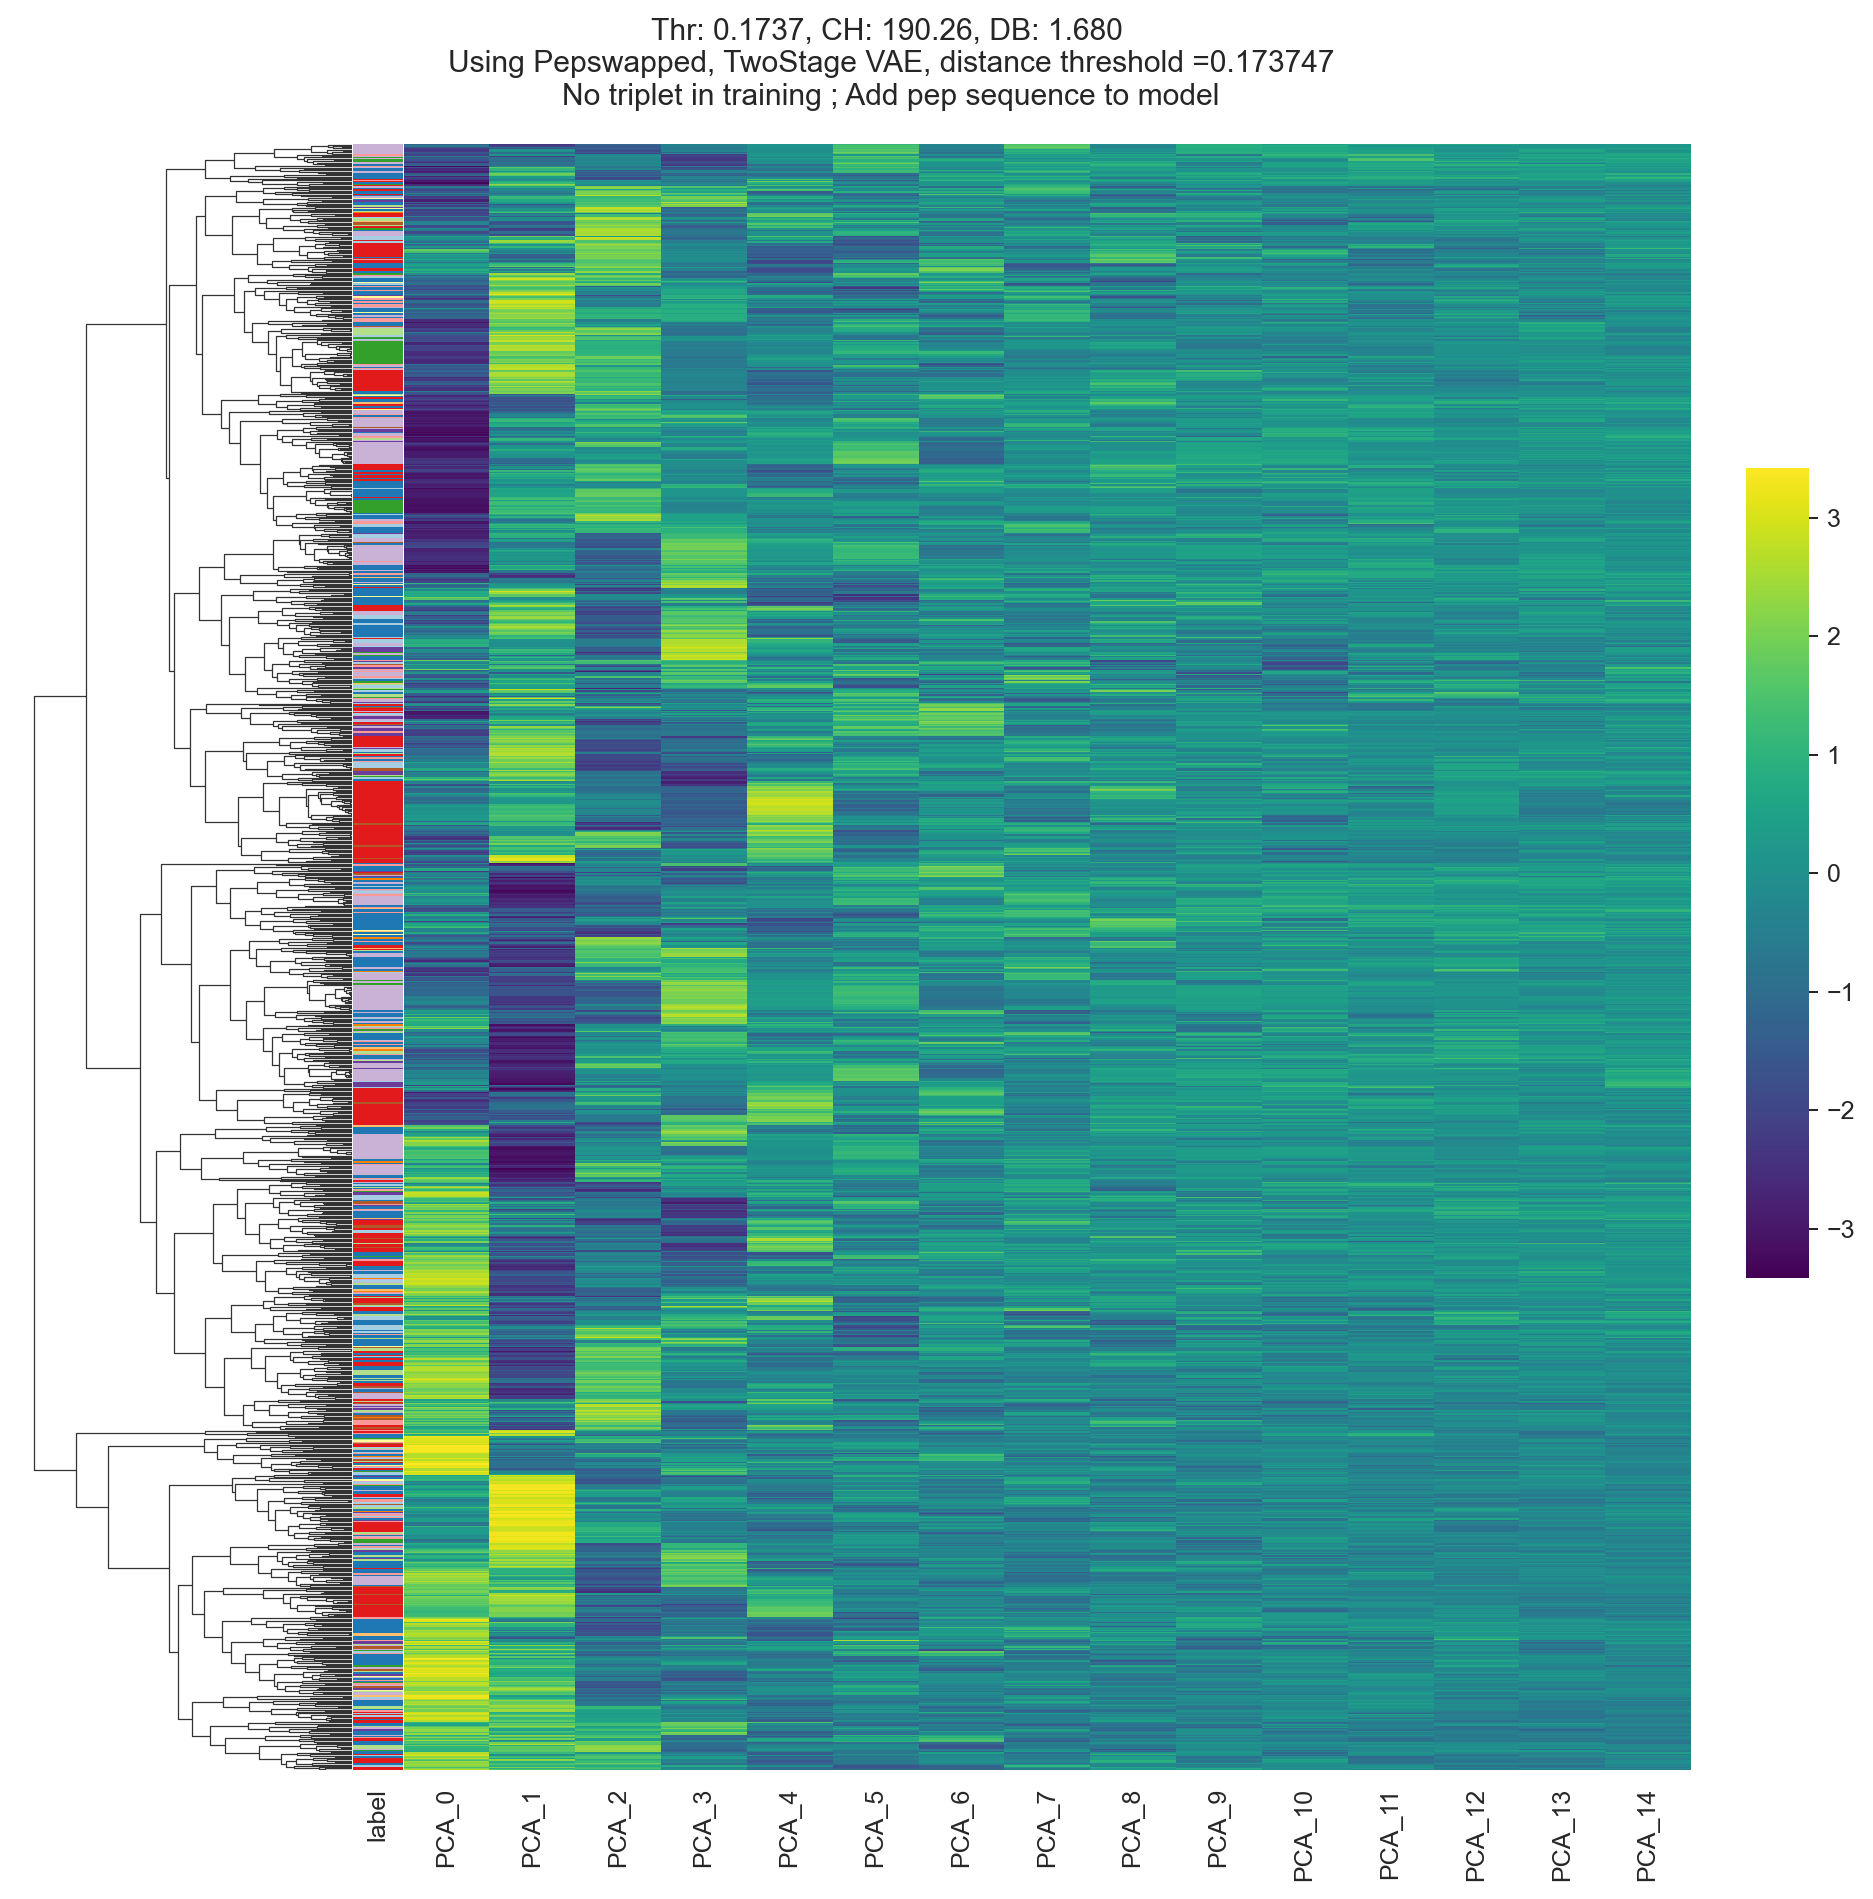

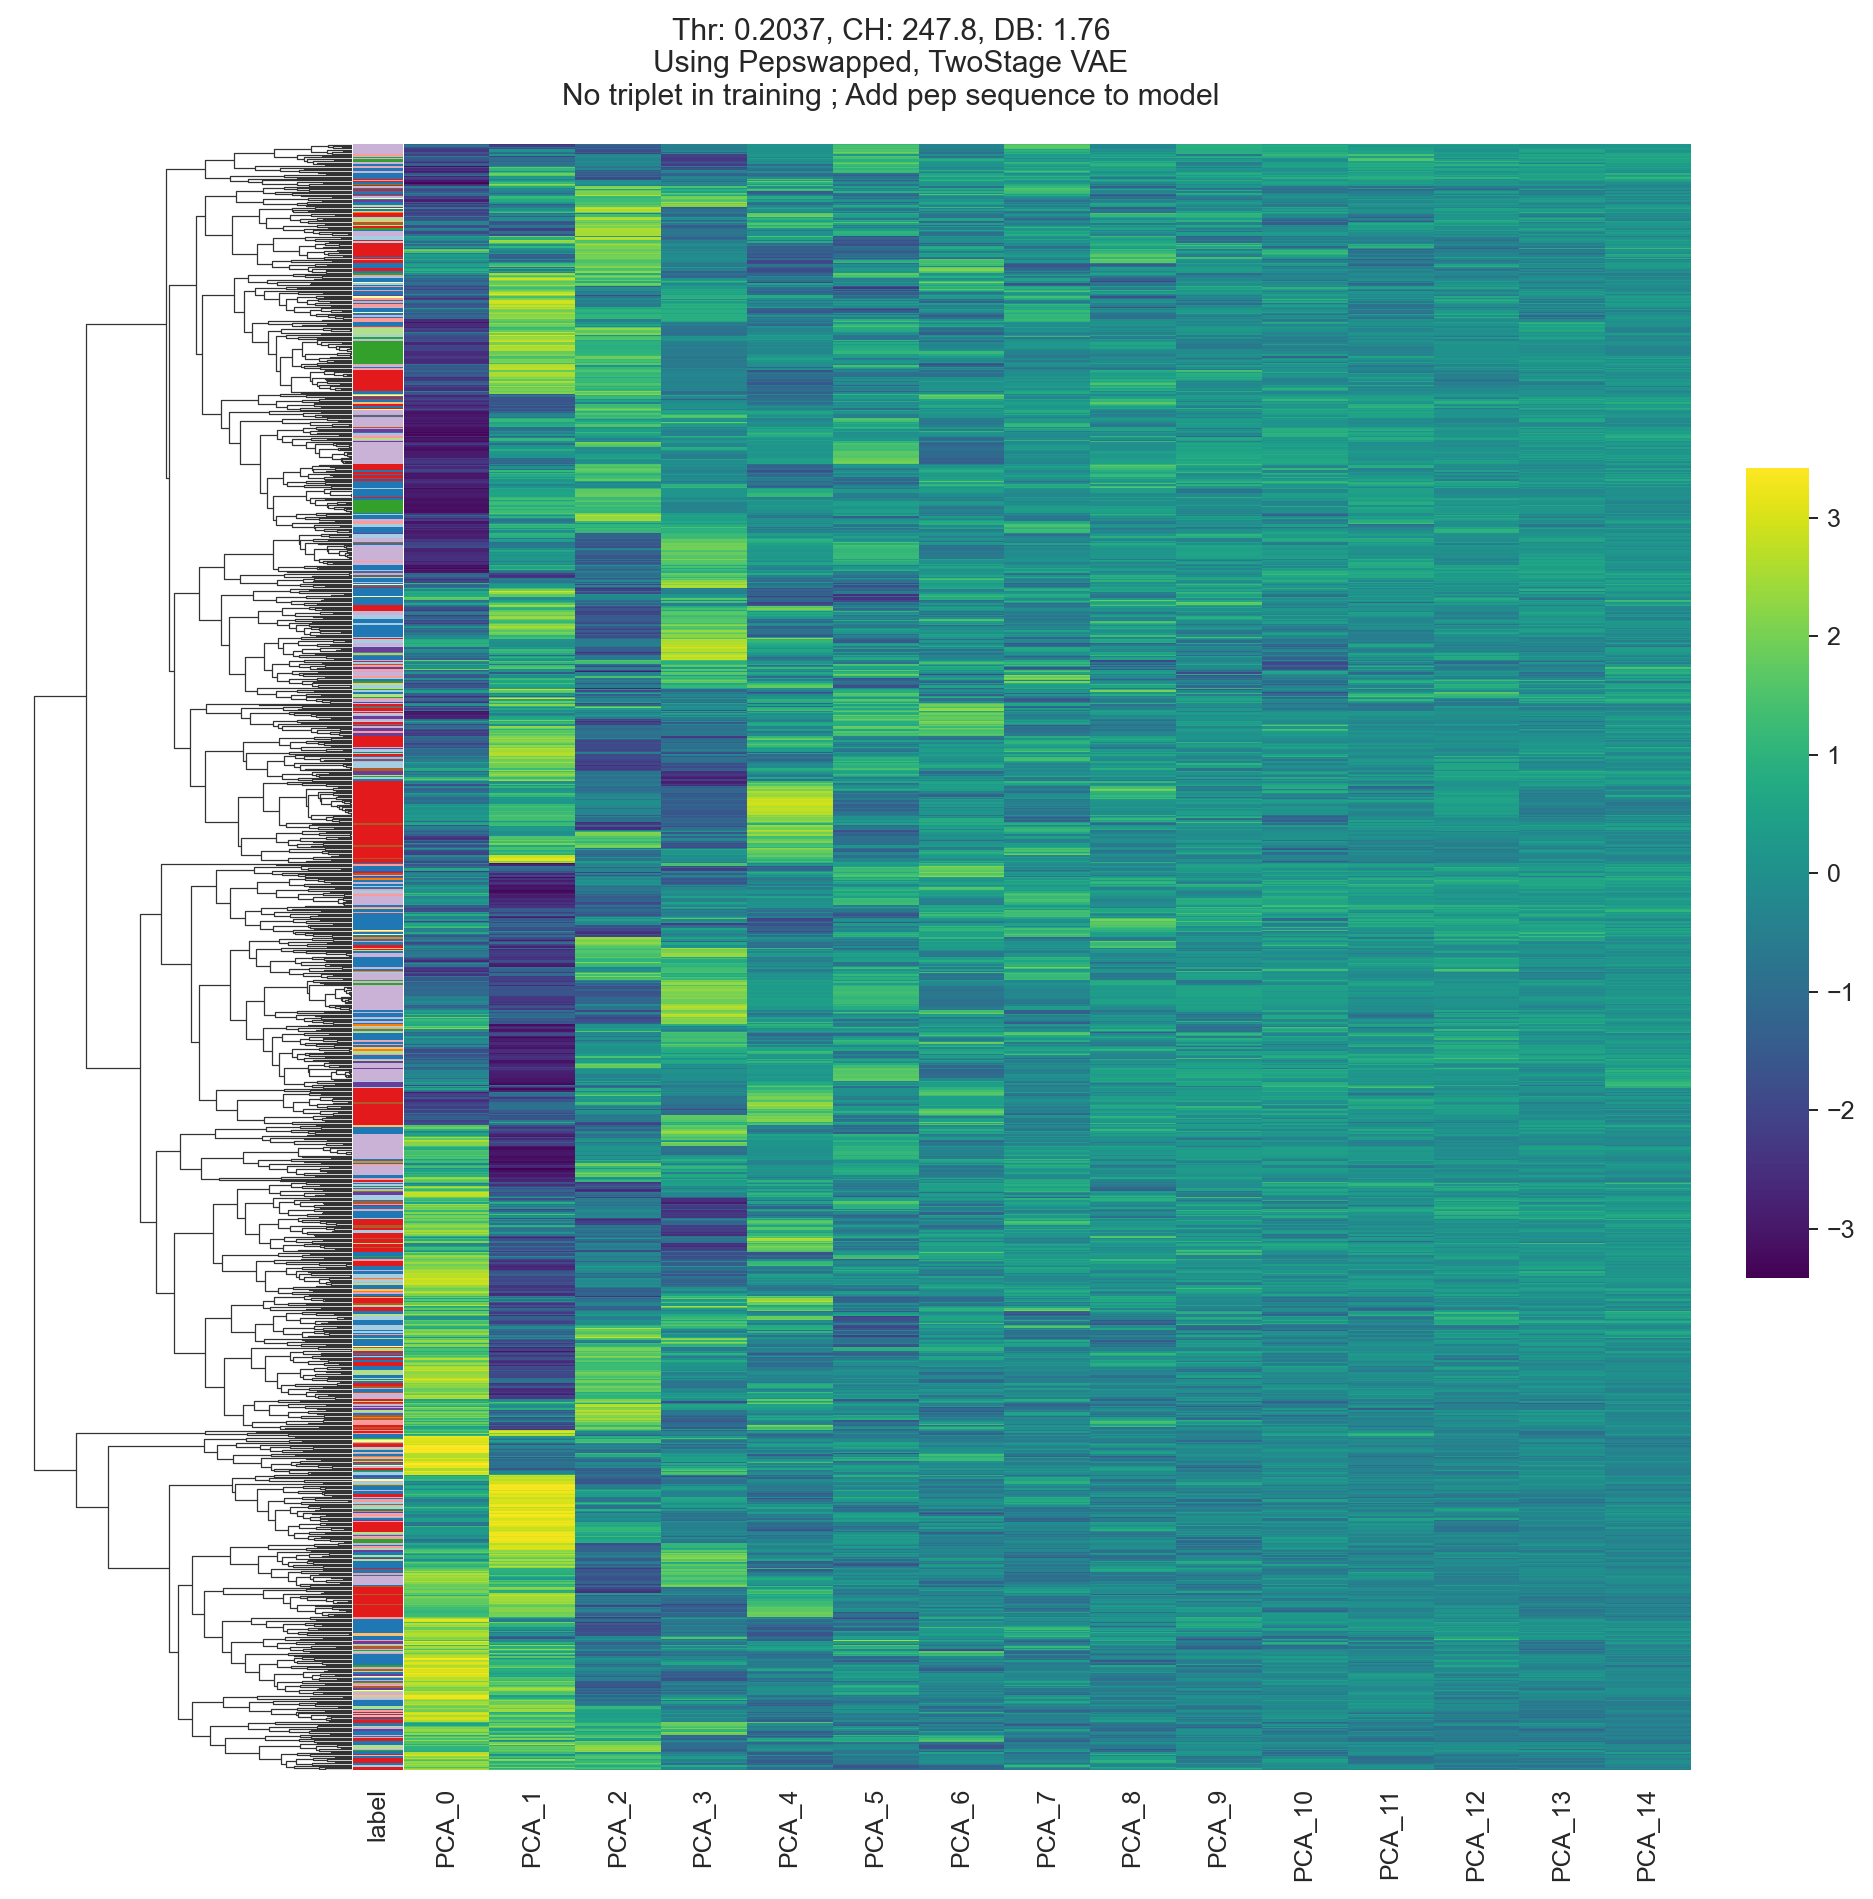

In [441]:

# 0.173747 and 0.203727
get_aggcluster_heatmap_plot(preds_ct, linkage='average', distance_threshold=0.461202,
                            title='Thr: 0.4612, CH: 108.499, DB: 1.81\n'
                                  'Using Pepswapped, cosine-triplet trained model \ncosine-loss only enabled for positives,'
                                  ' reconstruction/KLD trained for all datapoints',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_1stage_CosTrp.png')

get_aggcluster_heatmap_plot(preds_nt, linkage='complete', distance_threshold= 0.063527,
                            title='Thr: 0.0635, CH: 22.345, DB: 0.181\n'
                                  'Using Pepswapped, no-triplet trained model\nNormal training process',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_1stage_NoTrp.png')

get_aggcluster_heatmap_plot(preds_tight, linkage='average', distance_threshold=0.448858,
                            title='Thr: 0.4488, CH: 32.348, DB: 2.158\n'
                                  'Using Pepswapped, TwoStage VAE, cos-triplet trained model\n'
                                  'Cosine-Loss was enabled for all datapoints (old wrong behaviour)',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_OLD_2stage_CosTrp.png')

get_aggcluster_heatmap_plot(preds_2st_ct, linkage='average', distance_threshold=0.259279,
                            title='Thr: 0.2593, CH: 79.438, DB: 1.760 \n'
                                  'Using Pepswapped, TwoStage VAE'\
                            '\ncos-triplet trained model ; Cosine-Loss was enabled for pos only datapoints ',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_NEW_2stage_CosTrp_1.png')

get_aggcluster_heatmap_plot(preds_2st_ct, linkage='average', distance_threshold=0.332465,
                            title='Thr: 0.3325, CH: 167.84, DB: 2.105\n'
                                  'Using Pepswapped, TwoStage VAE'\
                            '\ncos-triplet trained model Cosine-Loss was enabled for pos only datapoints',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_NEW_2stage_CosTrp_1.png')

get_aggcluster_heatmap_plot(preds_2st_nt, linkage='average', distance_threshold=0.173747,
                            title='Thr: 0.1737, CH: 190.26, DB: 1.680 \n'
                            'Using Pepswapped, TwoStage VAE, distance threshold =0.173747'\
                            '\nNo triplet in training ; Add pep sequence to model',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_NEW_2stage_NoTrp_1.png')

get_aggcluster_heatmap_plot(preds_2st_nt, linkage='average', distance_threshold=0.203727,
                            title='Thr: 0.2037, CH: 247.8, DB: 1.76\n'
                            'Using Pepswapped, TwoStage VAE'\
                            '\nNo triplet in training ; Add pep sequence to model',
                            fn = '../output/240223_hierachical_clustering_heatmaps/PepSwap_NEW_2stage_CosTrp_1.png')



# custom algo tests

In [27]:
valid_ct.head(15)

TRDTTYYRNSFDEQNAFLYNQGGKLISGHDYFNNNVPASSPGSRGNIQY  \
TRDTTYYRNSFDEQNAFLYNQGGKLISGHDYFNNNVPASSPGSRGNIQY                                            0.000000   
YGATPYYFSGDTLVAVGAPSTSGTYKYIMGHRAYSYEKLASSQDPGF...                                           0.784137   
SSVPPYYTSAATLVAVKWSSNYKLTSQVTMANQGSEASVGSGDHGEQF                                             0.137610   
TRDTTYYRNSFDEQNALSEAGTGGSYIPTSGHTAFQGNSAASSGLEG...                                           0.663871   
ATGYPSATKADDKALLNYGNNRLASGHVSFQNEAQASSLVRDRAYEQY                                             0.534186   
YGATPYYFSGDTLVAGPNNFGNEKLTMNHEYSMNVEVASSRGTGFNEQY                                            0.326519   
DSASNYIRSNVGEAARETSYDKVISGHNSFNNNVPASRKQGSDTGELF                                             0.143629   
SIFNTLYKAGELAGPSNTGKLIMGHRAYSYEKLAVLVDPYNEQF                                                 0.739271   
DRGSQSIYSNGDAVNDQFYSGHNTYYREEEASSPGQLLMNTEAF                                                 0.820573   
NSASDYIRSNMDKADMNRDDKIILNHDASQIVNDASSIRAAYEQY                                                0.743524   
NSASQSVYSSGVVNGGDSSYKLISNHLYFYNNEIASSEGQVSPGELF                                              0.689980   
YGATPYYFSGDTLVAVGATNDYKLSLNHDASQIVNDASSSFLLSEQY                                              0.728830   
YGATPYYFSGDTLVAVGAGNNDMRSGHNSFNNNVPASSPQEGETQY                                               0.259231   
SSYSPSYTSAATLVVVSYNNAGNMLTSNHLYFYNNEIASSEAAVIYEQY                                            0.522231   
DSASNYIRSNVGEAARVRGFGNVLHMDHENSYDVKMASSLYSATGELF                                             0.647108   

                                                    YGATPYYFSGDTLVAVGAPSTSGTYKYIMGHRAYSYEKLASSQDPGFGGGSYEQY  \
TRDTTYYRNSFDEQNAFLYNQGGKLISGHDYFNNNVPASSPGSRGNIQY                                            0.784137         
YGATPYYFSGDTLVAVGAPSTSGTYKYIMGHRAYSYEKLASSQDPGF...                                           0.000000         
SSVPPYYTSAATLVAVKWSSNYKLTSQVTMANQGSEASVGSGDHGEQF                                             0.756856         
TRDTTYYRNSFDEQNALSEAGTGGSYIPTSGHTAFQGNSAASSGLEG...                                           0.427292         
ATGYPSATKADDKALLNYGNNRLASGHVSFQNEAQASSLVRDRAYEQY                                             0.542724         
YGATPYYFSGDTLVAGPNNFGNEKLTMNHEYSMNVEVASSRGTGFNEQY                                            0.538621         
DSASNYIRSNVGEAARETSYDKVISGHNSFNNNVPASRKQGSDTGELF                                             0.682811         
SIFNTLYKAGELAGPSNTGKLIMGHRAYSYEKLAVLVDPYNEQF                                                 0.507270         
DRGSQSIYSNGDAVNDQFYSGHNTYYREEEASSPGQLLMNTEAF                                                 0.496206         
NSASDYIRSNMDKADMNRDDKIILNHDASQIVNDASSIRAAYEQY                                                0.523435         
NSASQSVYSSGVVNGGDSSYKLISNHLYFYNNEIASSEGQVSPGELF                                              0.516544         
YGATPYYFSGDTLVAVGATNDYKLSLNHDASQIVNDASSSFLLSEQY                                              0.487907         
YGATPYYFSGDTLVAVGAGNNDMRSGHNSFNNNVPASSPQEGETQY                                               0.529548         
SSYSPSYTSAATLVVVSYNNAGNMLTSNHLYFYNNEIASSEAAVIYEQY                                            0.538261         
DSASNYIRSNVGEAARVRGFGNVLHMDHENSYDVKMASSLYSATGELF                                             0.498598         

                                                    SSVPPYYTSAATLVAVKWSSNYKLTSQVTMANQGSEASVGSGDHGEQF  \
TRDTTYYRNSFDEQNAFLYNQGGKLISGHDYFNNNVPASSPGSRGNIQY                                           0.137610   
YGATPYYFSGDTLVAVGAPSTSGTYKYIMGHRAYSYEKLASSQDPGF...                                          0.756856   
SSVPPYYTSAATLVAVKWSSNYKLTSQVTMANQGSEASVGSGDHGEQF                                            0.000000   
TRDTTYYRNSFDEQNALSEAGTGGSYIPTSGHTAFQGNSAASSGLEG...                                          0.728749   
ATGYPSATKADDKALLNYGNNRLASGHVSFQNEAQASSLVRDRAYEQY                          

In [49]:
threshold = 0.2
sample = torch.from_numpy(valid_ct.head(25)[[x for i,x in enumerate(valid_ct.columns[:25])]].values)
sorted, indices = sample.sort(dim=1)
thresholded_dists = sorted[sorted<=threshold]
thresholded_idxs = indices[sorted<=threshold]

In [50]:
import torch

threshold = 0.2
sorted, indices = sample.sort(dim=1)

# Create a mask for values below the threshold
mask = sorted >= threshold

# Set values below the threshold to some arbitrary value (e.g., -1)
sorted.masked_fill_(mask, -1)
indices.masked_fill_(mask, -1)

# Get the thresholded distances and indices
thresholded_dists = sorted[sorted != -1]
thresholded_idxs = indices[indices != -1]

# Check the result
print(thresholded_dists)
print(thresholded_idxs)


tensor([0.0000, 0.1376, 0.1436, 0.0000, 0.0000, 0.1376, 0.1497, 0.0000, 0.0000,
        0.0000, 0.1571, 0.1745, 0.0000, 0.1436, 0.1497, 0.0000, 0.1497, 0.1674,
        0.0000, 0.0000, 0.1205, 0.1497, 0.0000, 0.0000, 0.1205, 0.1674, 0.0000,
        0.1404, 0.1745, 0.0000, 0.1493, 0.0000, 0.1493, 0.0000, 0.0000, 0.0494,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1404, 0.1571, 0.0000, 0.0000,
        0.0494, 0.0000])
tensor([ 0,  2,  6,  1,  2,  0,  6,  3,  4,  5, 21, 12,  6,  0,  2,  7,  9, 11,
         8,  9, 11,  7, 10, 11,  9,  7, 12, 21,  5, 13, 14, 14, 13, 15, 16, 23,
        17, 18, 19, 20, 21, 12,  5, 22, 23, 16, 24])


In [51]:
indices

tensor([[ 0,  2,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 2,  0,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 5, 21, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 6,  0,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 7,  9, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1],
        [ 8, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [ ]:
# Define "intra_cluster_distance" threshold (cos dist)
# Define "inter_cluster_distance" threshold (cos dist)
# --> Defines a radius of in, a radius of out
# Pick "n_init" of random points ?

#
